# FIT5149 S1 2021: Applied Data Analysis 

## Assessment 2: Residential Energy Appliance Classification

### Group 19
Team Members
  + Member 1
    - Family Name: Jirasirikul
    - Given Name: Jirarote
    - Student ID: 31334679
    - Student email: jjir0001@student.monash.edu
  + Member 2
    - Family Name: Hase
    - Given Name: Mahesh Pandharinath
    - Student ID: 31094821
    - Student email: mhas0033@student.monash.edu
  + Member 3
    - Family Name: Sunthornjittanon
    - Given Name: Pichaphop
    - Student ID: 31258301
    - Student email: psun0009@student.monash.edu


Programming Language: R 4.0.2 in Jupyter Notebook 6.0.3


### Our final model (XGBoost) will take some time to run.

---


## Libraries & Global Variables

If not installed, kindly install new libraries using install.packages() command.

In [1]:
# For installation please remove comments for the selected libraries

  # install.packages('visdat')
  # install.packages('dplyr')
  # install.packages('gridExtra')
  # install.packages("psych")
  # install.packages('naniar')
  # install.packages("tsfeatures")
  # install.packages('reshape2')
  # install.packages('tidyverse')
  # install.packages('roll')
  # install.packages('xgboost')
  # install.packages('fastDummies')
  # install.packages('MLmetrics')
  # install.packages('vip')
  # install.packages('zoo')
  # install.packages("randomForest")
  # install.packages('splitTools')
  # install.packages("e1071")

In [2]:
# For identifying missing values
library(visdat)

# Use for wrangling data
library(dplyr) 

# For visusalisation
library(ggplot2)
library(gridExtra)

# for preview descriptive statistic
library(psych) 

# for cleaning dataset
library(naniar) 

# for sequential/ time-series characteristics
library(tsfeatures)

# For data transformation
library(reshape2)

# For wrangling the data
# library(tidyverse)
library(roll)

# For XGBoost
library(xgboost)
library(fastDummies)
library(MLmetrics)

# Plot important features
library(vip)

# Calculate rolling mean and sd
library(zoo)

# For Random Forest model
library(randomForest)

# For Splitting training and validation dataset
library(splitTools)

# For SVM
library(e1071)

Warning message:
"package 'visdat' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'psych' was built under R version 3.6.3"
Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Warning message:
"package 'tsfeatures' was built under R version 3.6.3"Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'roll' was built under R version 3.6.3"Warning message

In [3]:
# Global Variables

# Define list of Targets
target.vector = c('ac','ev','oven','wash','dryer')
SEED_NUMBER = 555


---


## Table of Contents

1. [Introduction](#sec_1)


2. [Data Preparation](#sec_2)


3. [Exploratory Data Analysis](#sec_3)


4. [Methodology](#sec_4)


5. [Model Development](#sec_5)


6. [Results and discussion](#sec_6)


7. [Conclusion](#sec_7)


8. [References](#sec_8)



---


## 1. Introduction <a class="anchor" id="sec_1"></a>

**The aim of this challenge** is to develop multiple classifiers for each individual target appliance
that can detect whether target appliances are being used in each time interval as correctly as possible. 


We will 


+ **develop five independent classifiers** to detect five appliances being used as accurate as possible


+ and **explain the outcomes** of the classifiers. For example, what features are strongly associated with the response variables and effective in the classification task.



---


## 2. Data Preparation<a class="anchor" id="sec_2"></a>

### Load the Dataset



In [4]:
# Read downloaded dataset and preview

# Please store the program file in the same folder containing train and test datasets
dat_train <- read.csv('train_data_withlabels.csv', header = TRUE, sep = ",")
dat_test <- read.csv('test_data_nolabels.csv', header = TRUE, sep = ",")

# Alternate way: In case relative path doesn't work. .
# dat_train <- read.csv(file = 'https://raw.githubusercontent.com/blizrys/FIT5149_REA_Classification/main/train_data_withlabels.csv')
# dat_test <- read.csv(file = 'https://raw.githubusercontent.com/blizrys/FIT5149_REA_Classification/main/test_data_nolabels.csv')



In [5]:
cat("Dataset Train size: ", dim(dat_train),"\n")
cat("Dataset Test size: ", dim(dat_test))

Dataset Train size:  417720 16 
Dataset Test size:  105540 11

**train data** contains 417,720 instances, each of which has 16 columns.

**test data** contains 105,540 instances, each of which has 11 columns.

In [6]:
# Missing variables summary table
miss_var_summary(dat_train)
# miss_var_summary(dat_test)

variable,n_miss,pct_miss
X,0,0
load,0,0
ac,0,0
ev,0,0
oven,0,0
wash,0,0
dryer,0,0
hourofday,0,0
dayofweek,0,0
dif,0,0


### Check missing data

To ensure there are no anomalies in the dataset. We perform a quick sweep of the data for null and na values.

* Training dataset does not have any missing values.



---


## 3. Exploratory Data Analysis <a class="anchor" id="sec_3"></a>

### Explore Data structure

In [7]:
# X : Unique identifier of each row
# X is a key, which does the same job as index. Hence, removing X from the training dataset.
train.data = select(dat_train, -c("X"))
test.data = select(dat_test, -c("X"))

**Five appliance labels** :
* 1 indicating using appliances and 
* 0 indicating not using appliances


These categorical columns to must be `transformed into factors`.

In [8]:
# transform categorical columns to factors
train.data <- train.data %>% 
                mutate(ac = as.factor(ac),
                       ev = as.factor(ev),
                       oven = as.factor(oven),
                       wash = as.factor(wash),
                       dryer =  as.factor(dryer),
                       dayofweek = as.factor(dayofweek)
                      )   

In [9]:
# Show the dimensions and data structure
cat("The training data set has ", dim(train.data)[1], "records and", dim(train.data)[2],
    "attributes. The structure of the dataset is shown belown:\n\n")

str(train.data)

# Show sample records
cat("\nThe sample records are")

head(train.data)

The training data set has  417720 records and 15 attributes. The structure of the dataset is shown belown:

'data.frame':	417720 obs. of  15 variables:
 $ load     : num  2.25 2.26 2.27 2.27 2.27 ...
 $ ac       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ev       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ oven     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ wash     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ dryer    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ hourofday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ dayofweek: Factor w/ 7 levels "Fri","Mon","Sat",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ dif      : num  0.987 0.014 0.01 -0.001 0.002 ...
 $ absdif   : num  0.987 0.014 0.01 0.001 0.002 ...
 $ max      : num  6.21 6.21 6.21 6.21 6.21 ...
 $ var      : num  3.07 3.17 3.27 3.3 3.3 ...
 $ entropy  : num  0.679 0.667 0.648 0.629 0.621 ...
 $ nonlinear: num  0.0529 0.0548 0.057 0.0576 0.0826 ...
 $ hurst    : num  0.994 0.994 0.994 0.

load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.6788858,0.05290291,0.9940715
2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.6674503,0.05482926,0.9941540
2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.6477770,0.05699074,0.9942200
2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.6292270,0.05760593,0.9941497
2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406
2.259,0,0,0,0,0,0,Sun,-0.011,0.011,6.215,3.298258,0.6269564,0.08978753,0.9939864


**15 columns include**

1. **Main Feature:** <font color="blue">load</font> - Residential aggregate load data from measurement.


2. **Target Variables** :
    - <font color="red">ac</font> - Air Condition Status (Not used =0 , Used =1)
    - <font color="red">ev</font> - Electric Vehicle Charger Status (Not used =0 , Used =1)
    - <font color="red">oven</font> - Oven Status (Not used =0 , Used =1)
    - <font color="red">wash</font> - Cloth washer Status (Not used =0 , Used =1)
    - <font color="red">dryer</font> - Dryer Status (Not used =0 , Used =1)


3. **Features of Timestamps** :
    - <font color="blue">hour of the day</font>
    - <font color="blue">day of the week </font>
    
    
4. **Features from tsfeatures library** :
    - <font color="blue">dif</font> -  Difference between two sequential load data points.
    - <font color="blue">absdif</font> - Absolute value of dif.
    - <font color="blue">max</font> - Maximum load during last one hour.
    - <font color="blue">var</font> - Variance of load over a neighborhood time window of 30 minutes around each load data point.
    - <font color="blue">entropy</font> - The Shannon entropy that measures the "forecastability" of a time series data, where low values indicate a high signal-to-noise ratio and large values occur when a series is difficult to forecast.
    - <font color="blue">nonlinear</font> - The nonlinearity coefficient is used in Terasvirta’s nonlinearity test. Teräsvirta’s test uses a statistic X2=Tlog(SSE1/SSE0) where SSE1 and SSE0 are the sum of squared residuals from a nonlinear and linear autoregression respectively. This takes large values when the series is nonlinear, and values around 0 when the series is linear.
    - <font color="blue">hurst</font> - The hurst is used as a measure of the long-term memory of a time series. We use a measure of the long-term memory of a time series (hurst), computed as 0.5 plus the maximum likelihood estimate of the fractional differencing order.

Note: all the load data are minute-by-minute meter readings in a **sequential manner**. Therefore, `each Row represent each minute`.

Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html 

### Explore Load

As we know that `Load` is the Main predictor in our focus, We chose to explore the load first and separately as it will make us understand how our data behave. 

#### Preview of the House load w.r.t. time along with Device status (ON / OFF)

In [10]:
# Storing indices of the dataset
dat_preview = dat_train
dat_preview$idx <- as.numeric(row.names(dat_preview))

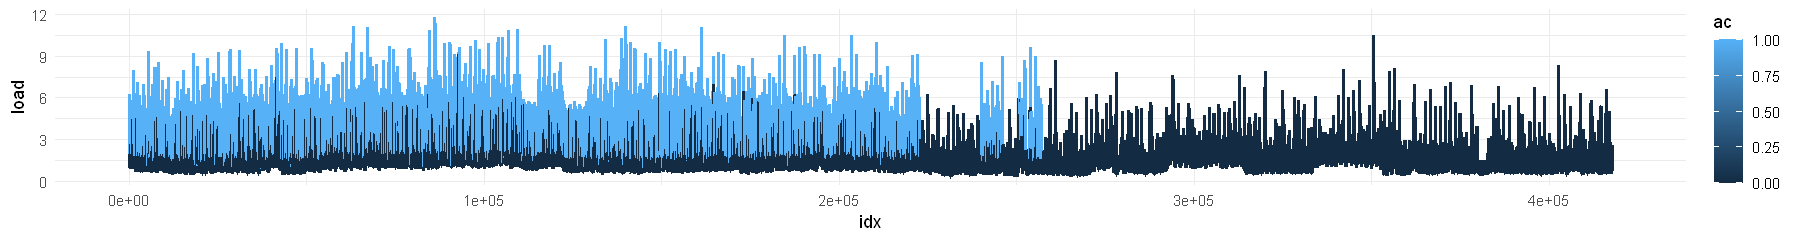

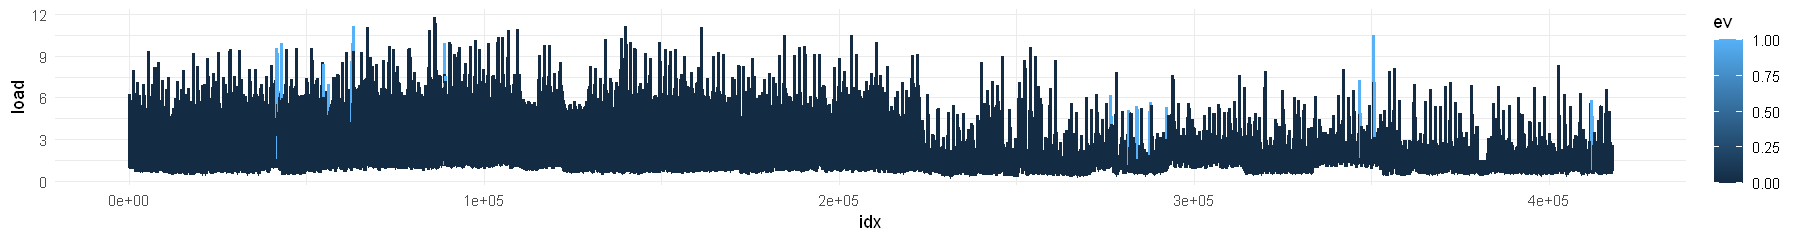

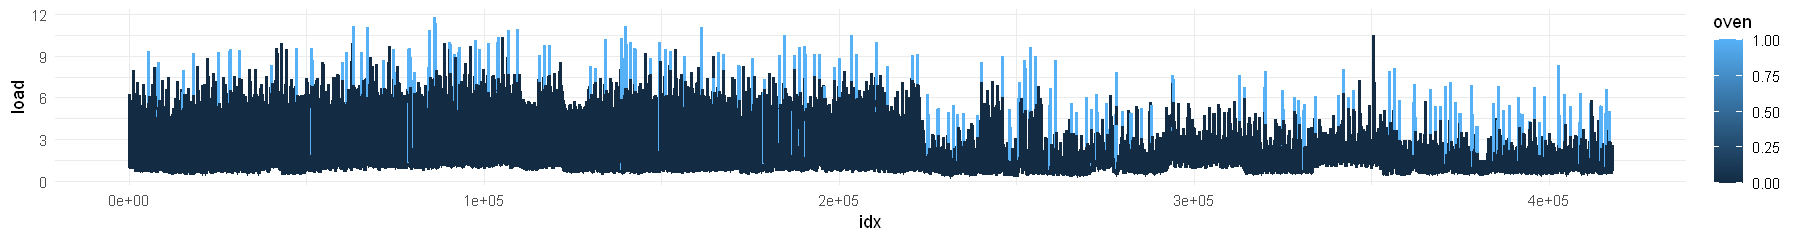

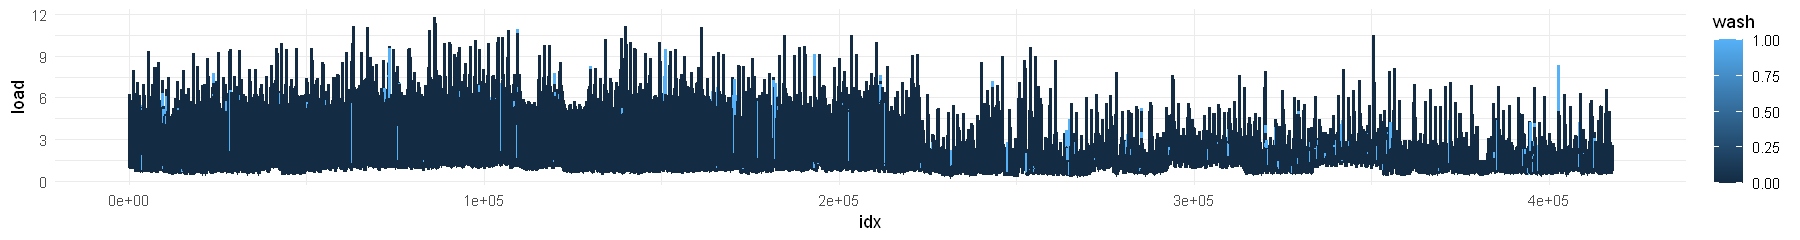

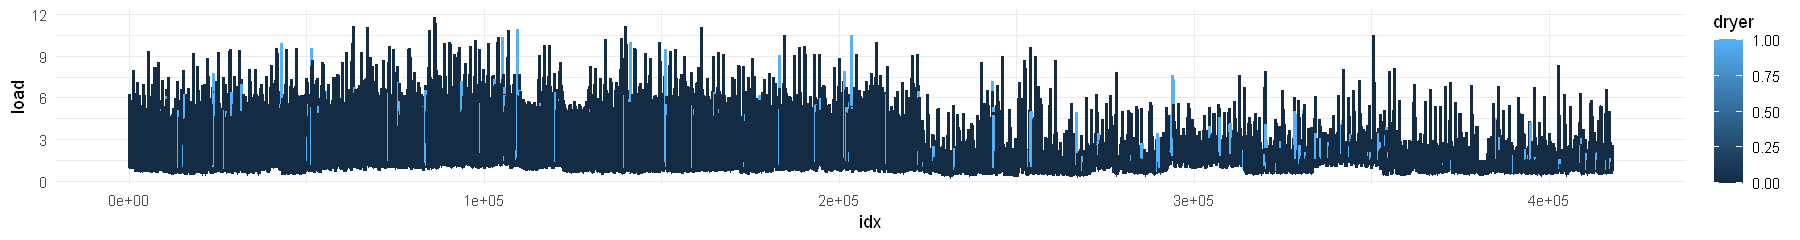

In [11]:
# Display load with respect to each target throughout entire data

# Multiple line plot
options(repr.plot.width=15, repr.plot.height=2)

# Creating a placeholder
all_plot = c()

# For each target variable
for(i in target.vector){
#   cat(i)

  # Plot the graph
  print(ggplot(dat_preview[1:nrow(dat_preview),], aes(x = idx, y = load)) +
    # geom_line(aes(color = ac),size = 1) +
    geom_line(aes_string(color = i),size = 1) +
    # scale_color_manual(values = c("#132c43", "#5db1f3")) +
    theme_minimal())
}

* Above plot displays variation of the load for entire dataset. It also indicates when a particular device is switched ON (as shown by light blue color in the plot). 

* Different target variables / devices show different patterns when load is plotted against the timeline.
  - **ac** is on during first half of the session (approximately).
  - **ev** is intermittently ON during the entire time.
  - **oven** is almost ON throughout the session. 
  - Both **wash** and **dryer** are intermittently ON, but their patterns are very similar to each other.

* This calls for further analysis as well as need for **stratified sampling** for the cross-validation.

#### Preview Zoom of load w.r.t each target type :

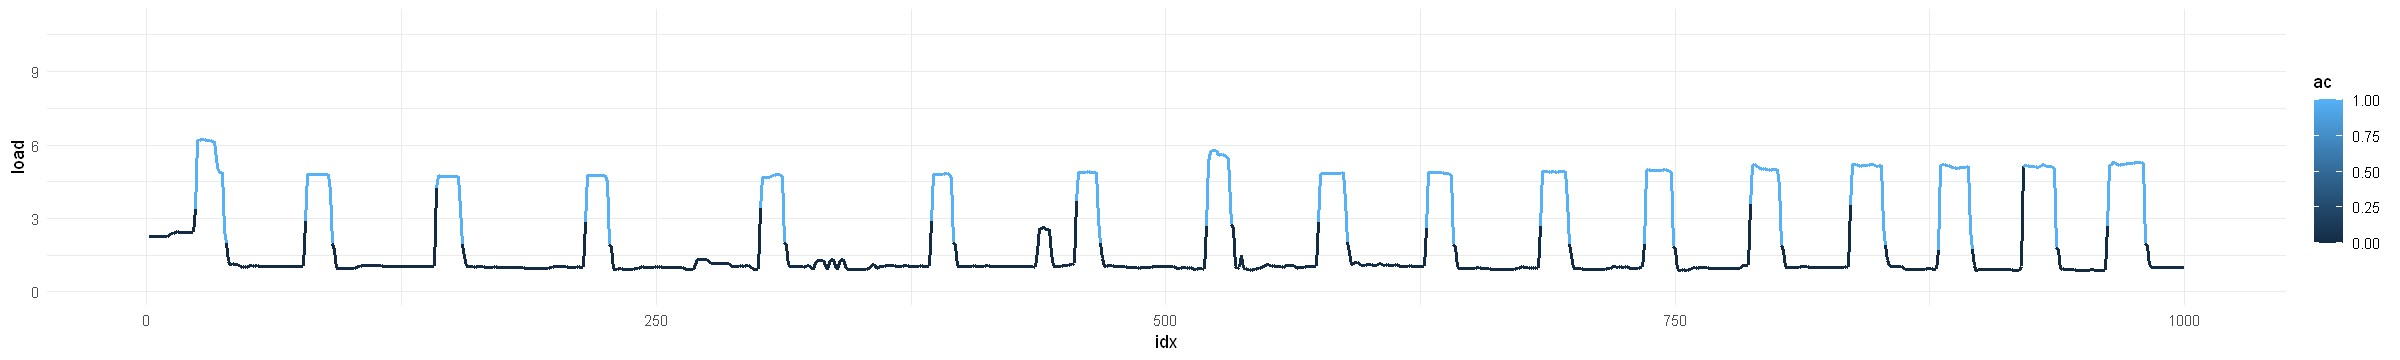

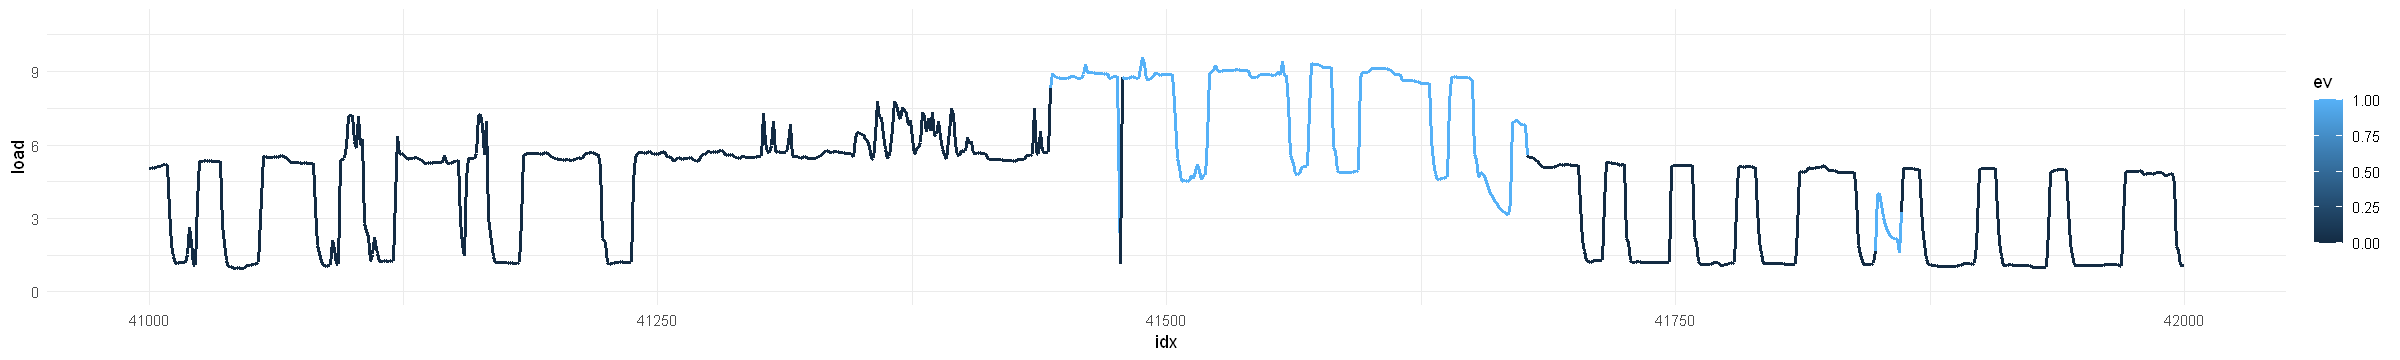

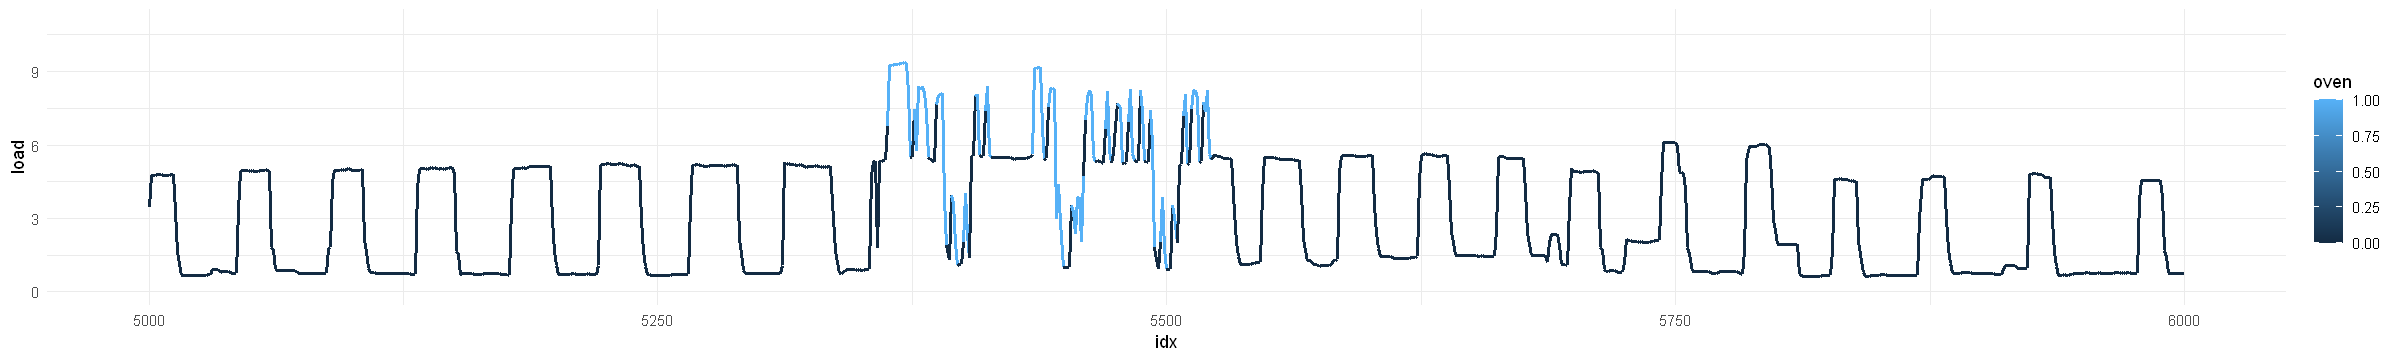

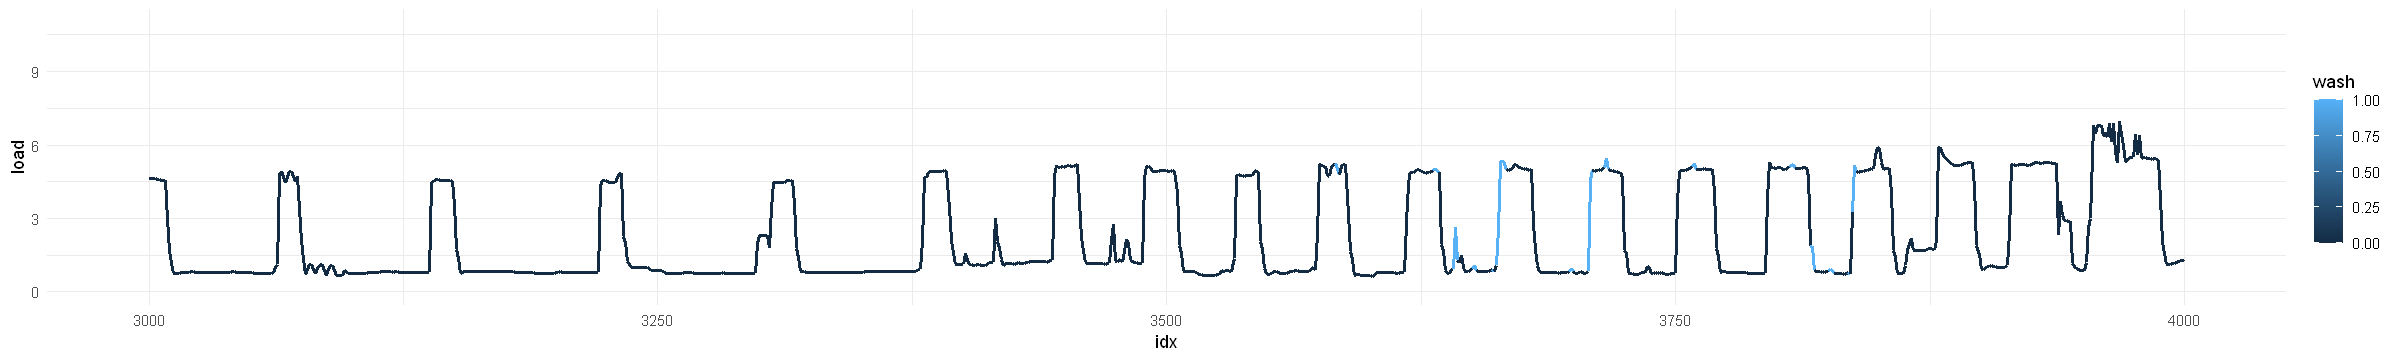

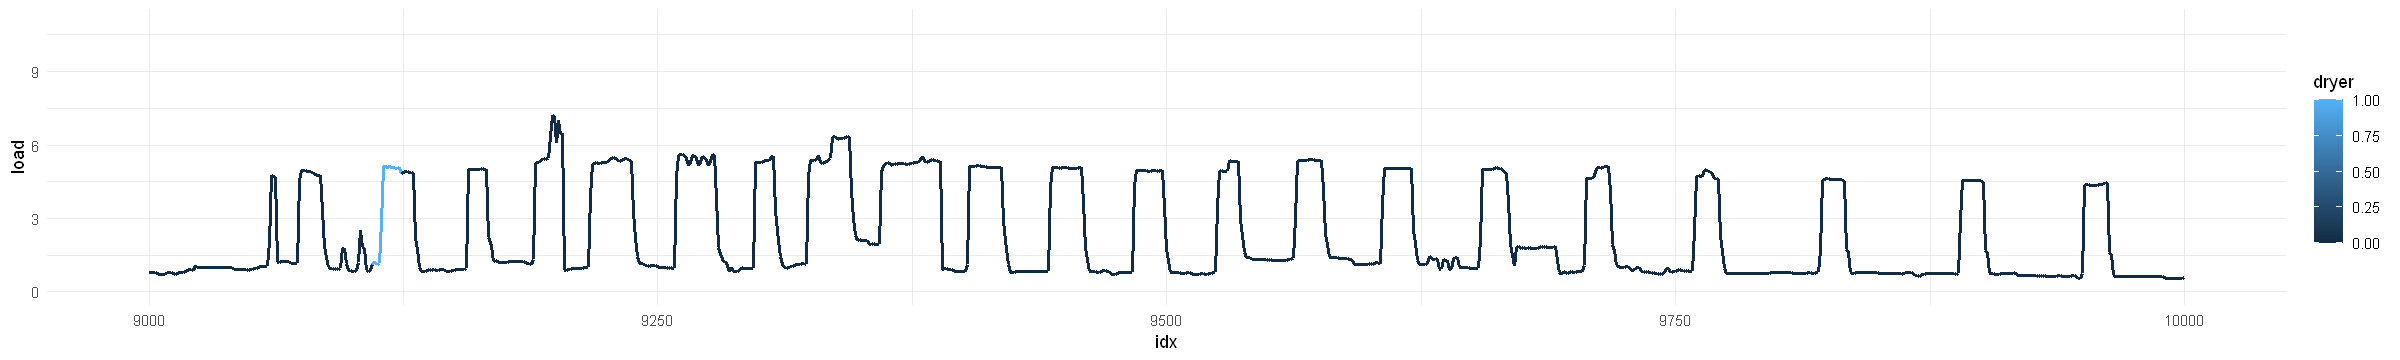

In [12]:
# Multiple line plot
options(repr.plot.width=20, repr.plot.height=3)

# For each target variable
for(i in target.vector){
    # cat(i)
    index = dat_preview %>% filter(!!as.symbol(i) == 1)  %>% head(1)['idx']
    # cat(i,index,"\n")
    start = floor(index/1000)*1000
    end = start+1000

    print(ggplot(dat_preview[start:end,], aes(x = idx, y = load)) +
      geom_line(aes_string(color = i),size = 1) +
      ylim(0,11) +
      # scale_color_manual(values = c("#00AFBB", "#1A74E2")) +
      theme_minimal())
}

We identify load characteristic of each target behaviour on the loads. 

* `ac` has its own spike when the device is turn ON. 

* `ev` and `oven` show on top behaviour to an existing pattern before and after devices are ON. 

* `wash` and `dryer` are unconclusive.

### Explore Target

#### Investigate distribution of target variables

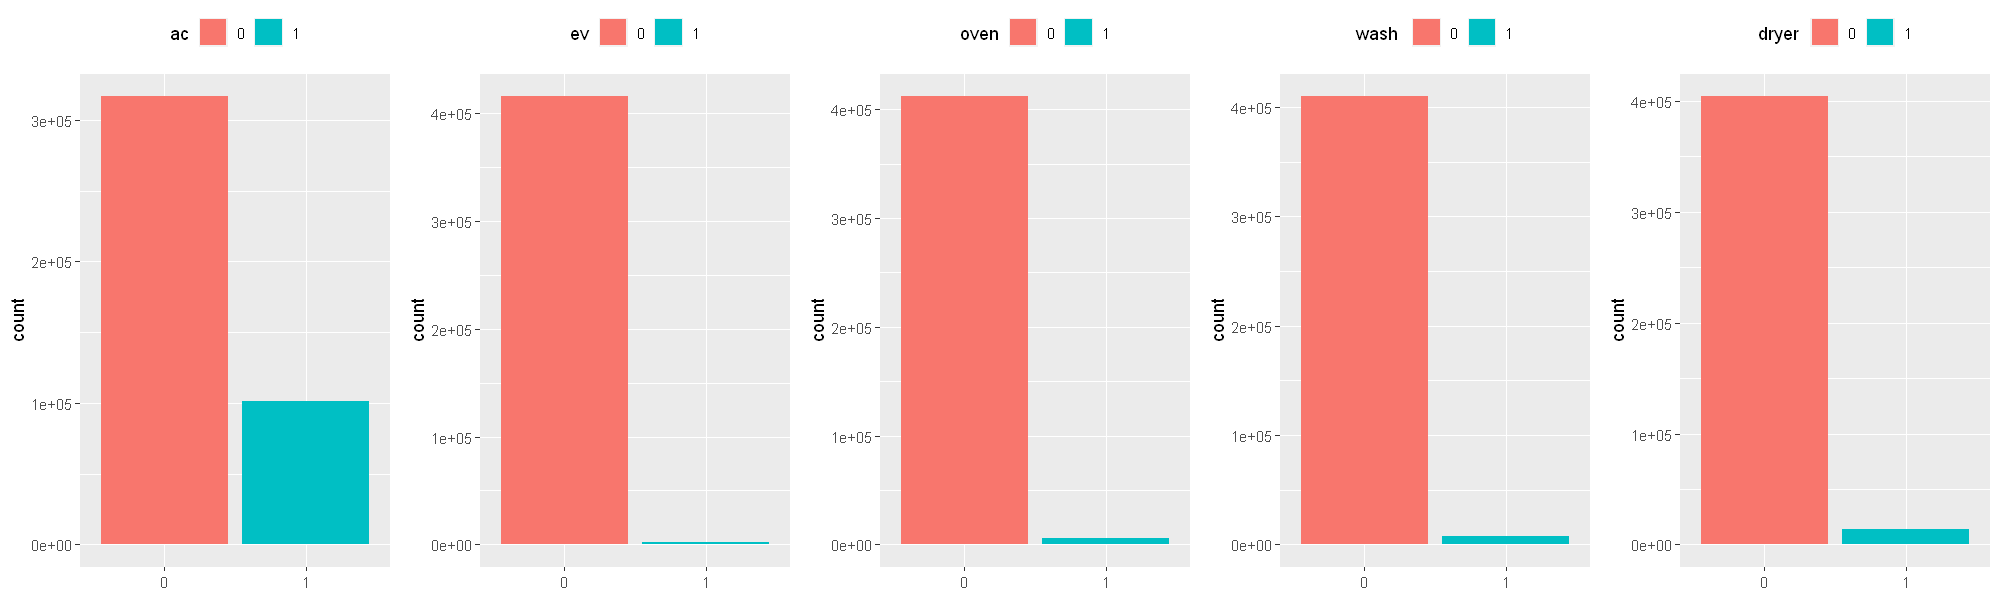

In [13]:
# Target Distribution
p1 <- ggplot(train.data,aes(x= as.factor(ac))) +
      geom_bar(aes(fill =as.factor(ac)))+
      labs(fill = "ac")+
      theme(axis.title.x=element_blank(),legend.position="top")

p2 <- ggplot(train.data,aes(x= as.factor(ev))) +
      geom_bar(aes(fill =as.factor(ev)))+
      labs(fill = "ev")+
      theme(axis.title.x=element_blank(),legend.position="top")

p3 <- ggplot(train.data,aes(x= as.factor(oven))) +
      geom_bar(aes(fill =as.factor(oven)))+
      labs(fill = "oven")+
      theme(axis.title.x=element_blank(),legend.position="top")

p4 <- ggplot(train.data,aes(x= as.factor(wash))) +
      geom_bar(aes(fill =as.factor(wash)))+
      labs(fill = "wash")+
      theme(axis.title.x=element_blank(),legend.position="top")

p5 <- ggplot(train.data,aes(x= as.factor(dryer))) +
      geom_bar(aes(fill =as.factor(dryer)))+
      labs(fill = "dryer")+
      theme(axis.title.x=element_blank(),legend.position="top")


# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 5)


grid.arrange(p1, p2, p3, p4, p5, nrow = 1, ncol =5)

* Above plots confirms the **skewed distribution** of ON and OFF status of all target variables.

* Some variables such as **ev** are ON very few occasions as compared with their OFF status.

* We should take this factor in consideration while building and comparing our models on different parameters. We should avoid using **accuracy** metric while comparing models, because even predicting 0 (OFF status) every time without building model will yield **High accuracy** score.

* Hence, in this case, we should rely on **Precision, recall and F1 score** to compare our models since these performance metrics are more suitable for the skewed data.

### Explore Predictors

#### Qualitative predictors:

##### Check distribution of the data for different time features

In [14]:
# Show Frequency of hours of day in train dataset
table(train.data$hourofday)


    0     1     2     3     4     5     6     7     8     9    10    11    12 
17400 17460 17460 17460 17460 17460 17460 17460 17400 17400 17460 17400 17400 
   13    14    15    16    17    18    19    20    21    22    23 
17400 17400 17400 17400 17400 17340 17340 17340 17340 17340 17340 

In [15]:
# Show Frequency of day of week in train dataset
table(train.data$dayofweek)


  Fri   Mon   Sat   Sun   Thu   Tue   Wed 
58260 61440 58080 59940 59040 60480 60480 

* This implies that time-data i.e. Hours in a day and Number of days in a week are almost **evenly distributed**.

* This rules out doubt of selecting `specific time period` (e.g. peak period) or `choosing only weekdays` in the given training dataset from analysis.

#### Seasonal Effect Investigation

#### Time wise (Day/Hour) Analysis of the Load

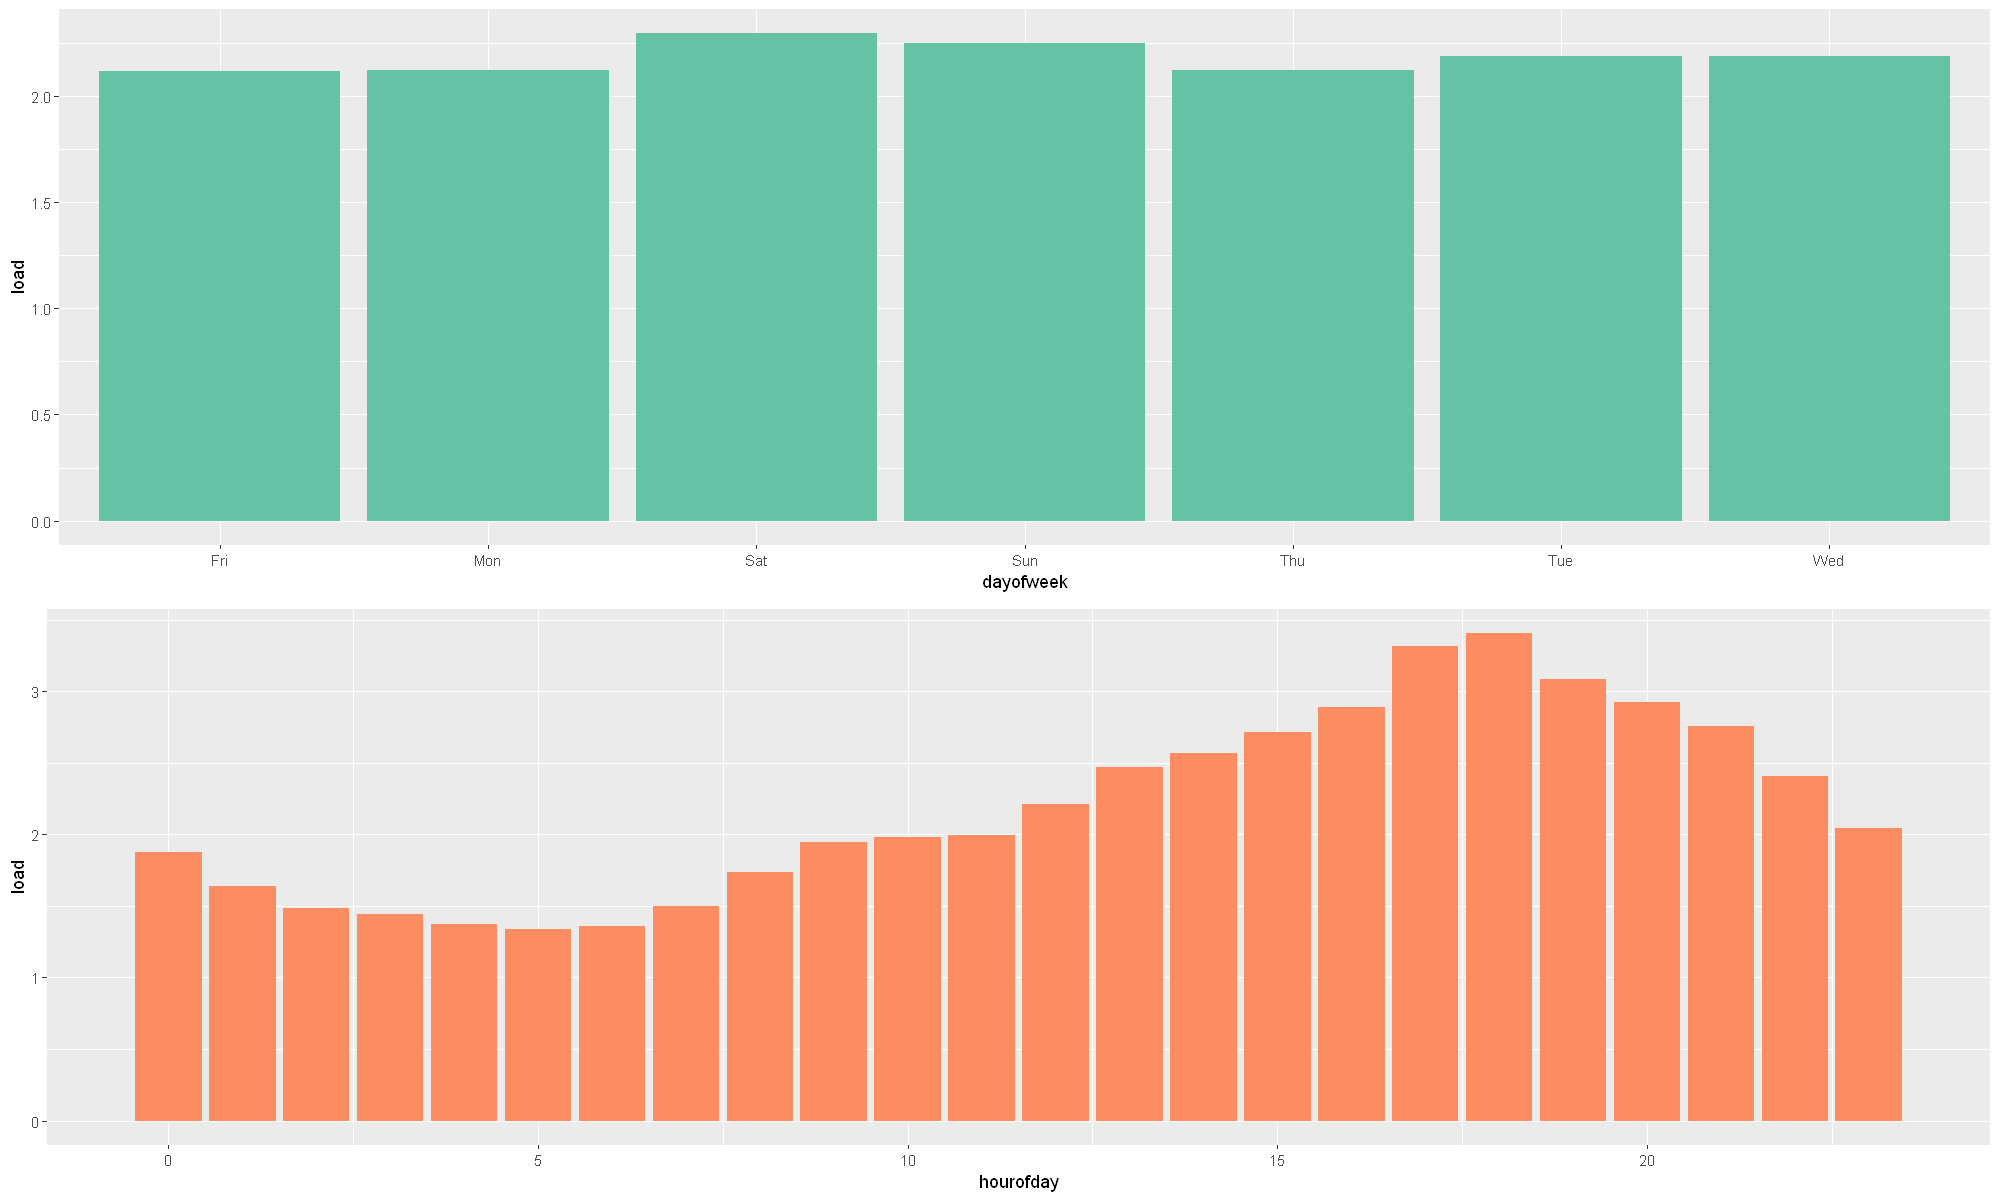

In [16]:
# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 10)

p1 <- ggplot(train.data,aes(x=dayofweek, y=load)) +
    geom_bar(stat = "summary", fun = "mean", fill ='#66c2a5')

p2 <- ggplot(train.data,aes(x=hourofday, y=load)) +
    geom_bar(stat = "summary", fun = "mean", fill ='#fc8d62')

grid.arrange(p1, p2,nrow = 2)

In [17]:
# Aggregate data by day of week and hour of day

# Aggregate data by day of week
dayofweek.agg <-train.data %>%
                    # Group by day of week
                    group_by(dayofweek) %>%
                    # Calculate % appliance usage
                    summarise(ac = sum(as.numeric(as.character(ac)))/n(),
                              ev = sum(as.numeric(as.character(ev)))/n(),
                              oven = sum(as.numeric(as.character(oven)))/n(),
                              wash  = sum(as.numeric(as.character(wash)))/n(),
                              dryer  = sum(as.numeric(as.character(dryer)))/n()) %>%
                    mutate(dayofweek =factor(dayofweek, levels = c("Mon", "Tue", "Wed","Thu","Fri","Sat","Sun"))) 


# Aggregate data by hour of day
hourofday.agg <-train.data %>%
                    # Group by hour of day
                    group_by(hourofday) %>%
                    # Calculate % appliance usage
                    summarise(ac = sum(as.numeric(as.character(ac)))/n(),
                              ev = sum(as.numeric(as.character(ev)))/n(),
                              oven = sum(as.numeric(as.character(oven)))/n(),
                              wash  = sum(as.numeric(as.character(wash)))/n(),
                              dryer  = sum(as.numeric(as.character(dryer)))/n()
             )

# dayofweek.agg

# hourofday.agg

#### Percentage usage of  each appliance by hour of day

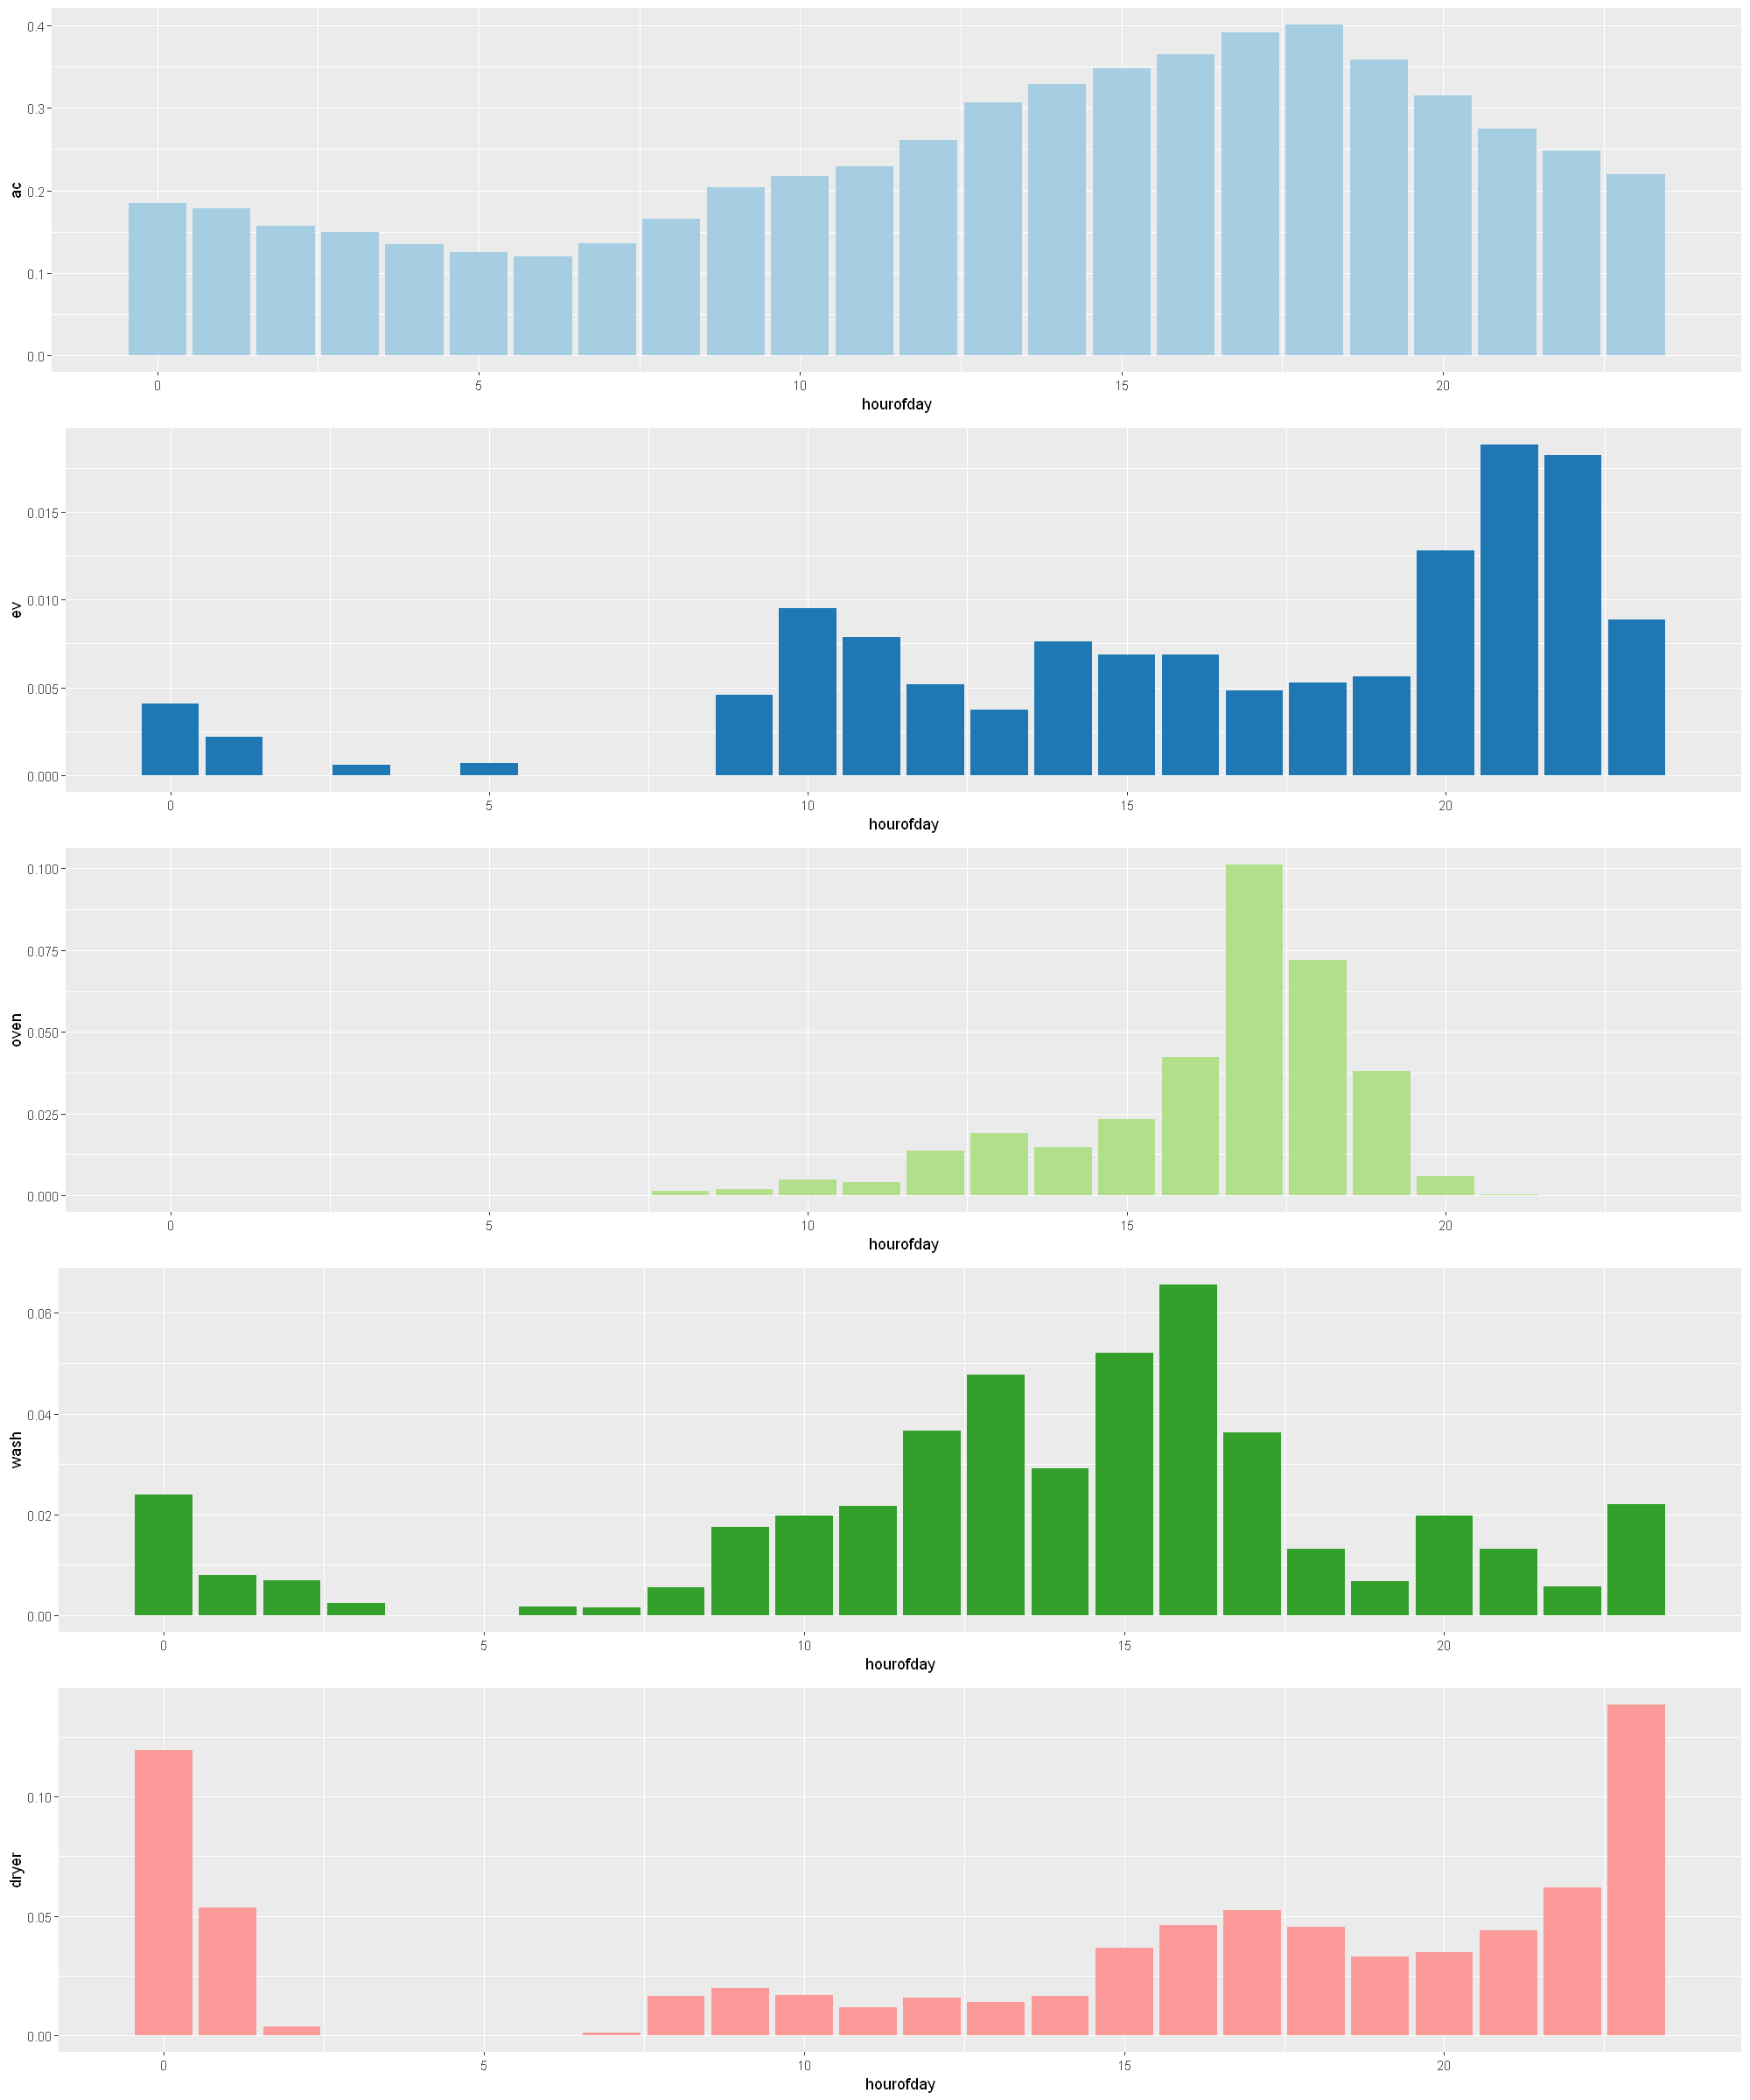

In [18]:
# Plot % usage by hour of day

# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 20)

p1 <-ggplot(hourofday.agg, aes(x=hourofday,y=ac)) +
    geom_col(fill='#a6cee3')

p2 <-ggplot(hourofday.agg, aes(x=hourofday,y=ev)) +
    geom_col(fill='#1f78b4')

p3 <-ggplot(hourofday.agg, aes(x=hourofday,y=oven)) +
    geom_col(fill='#b2df8a')

p4<-ggplot(hourofday.agg, aes(x=hourofday,y=wash)) +
    geom_col(fill='#33a02c')

p5<-ggplot(hourofday.agg, aes(x=hourofday,y=dryer)) +
    geom_col(fill='#fb9a99')

grid.arrange(p1, p2,p3, p4,p5 ,nrow = 5)

#### Percentage usage of  each appliance by day of week

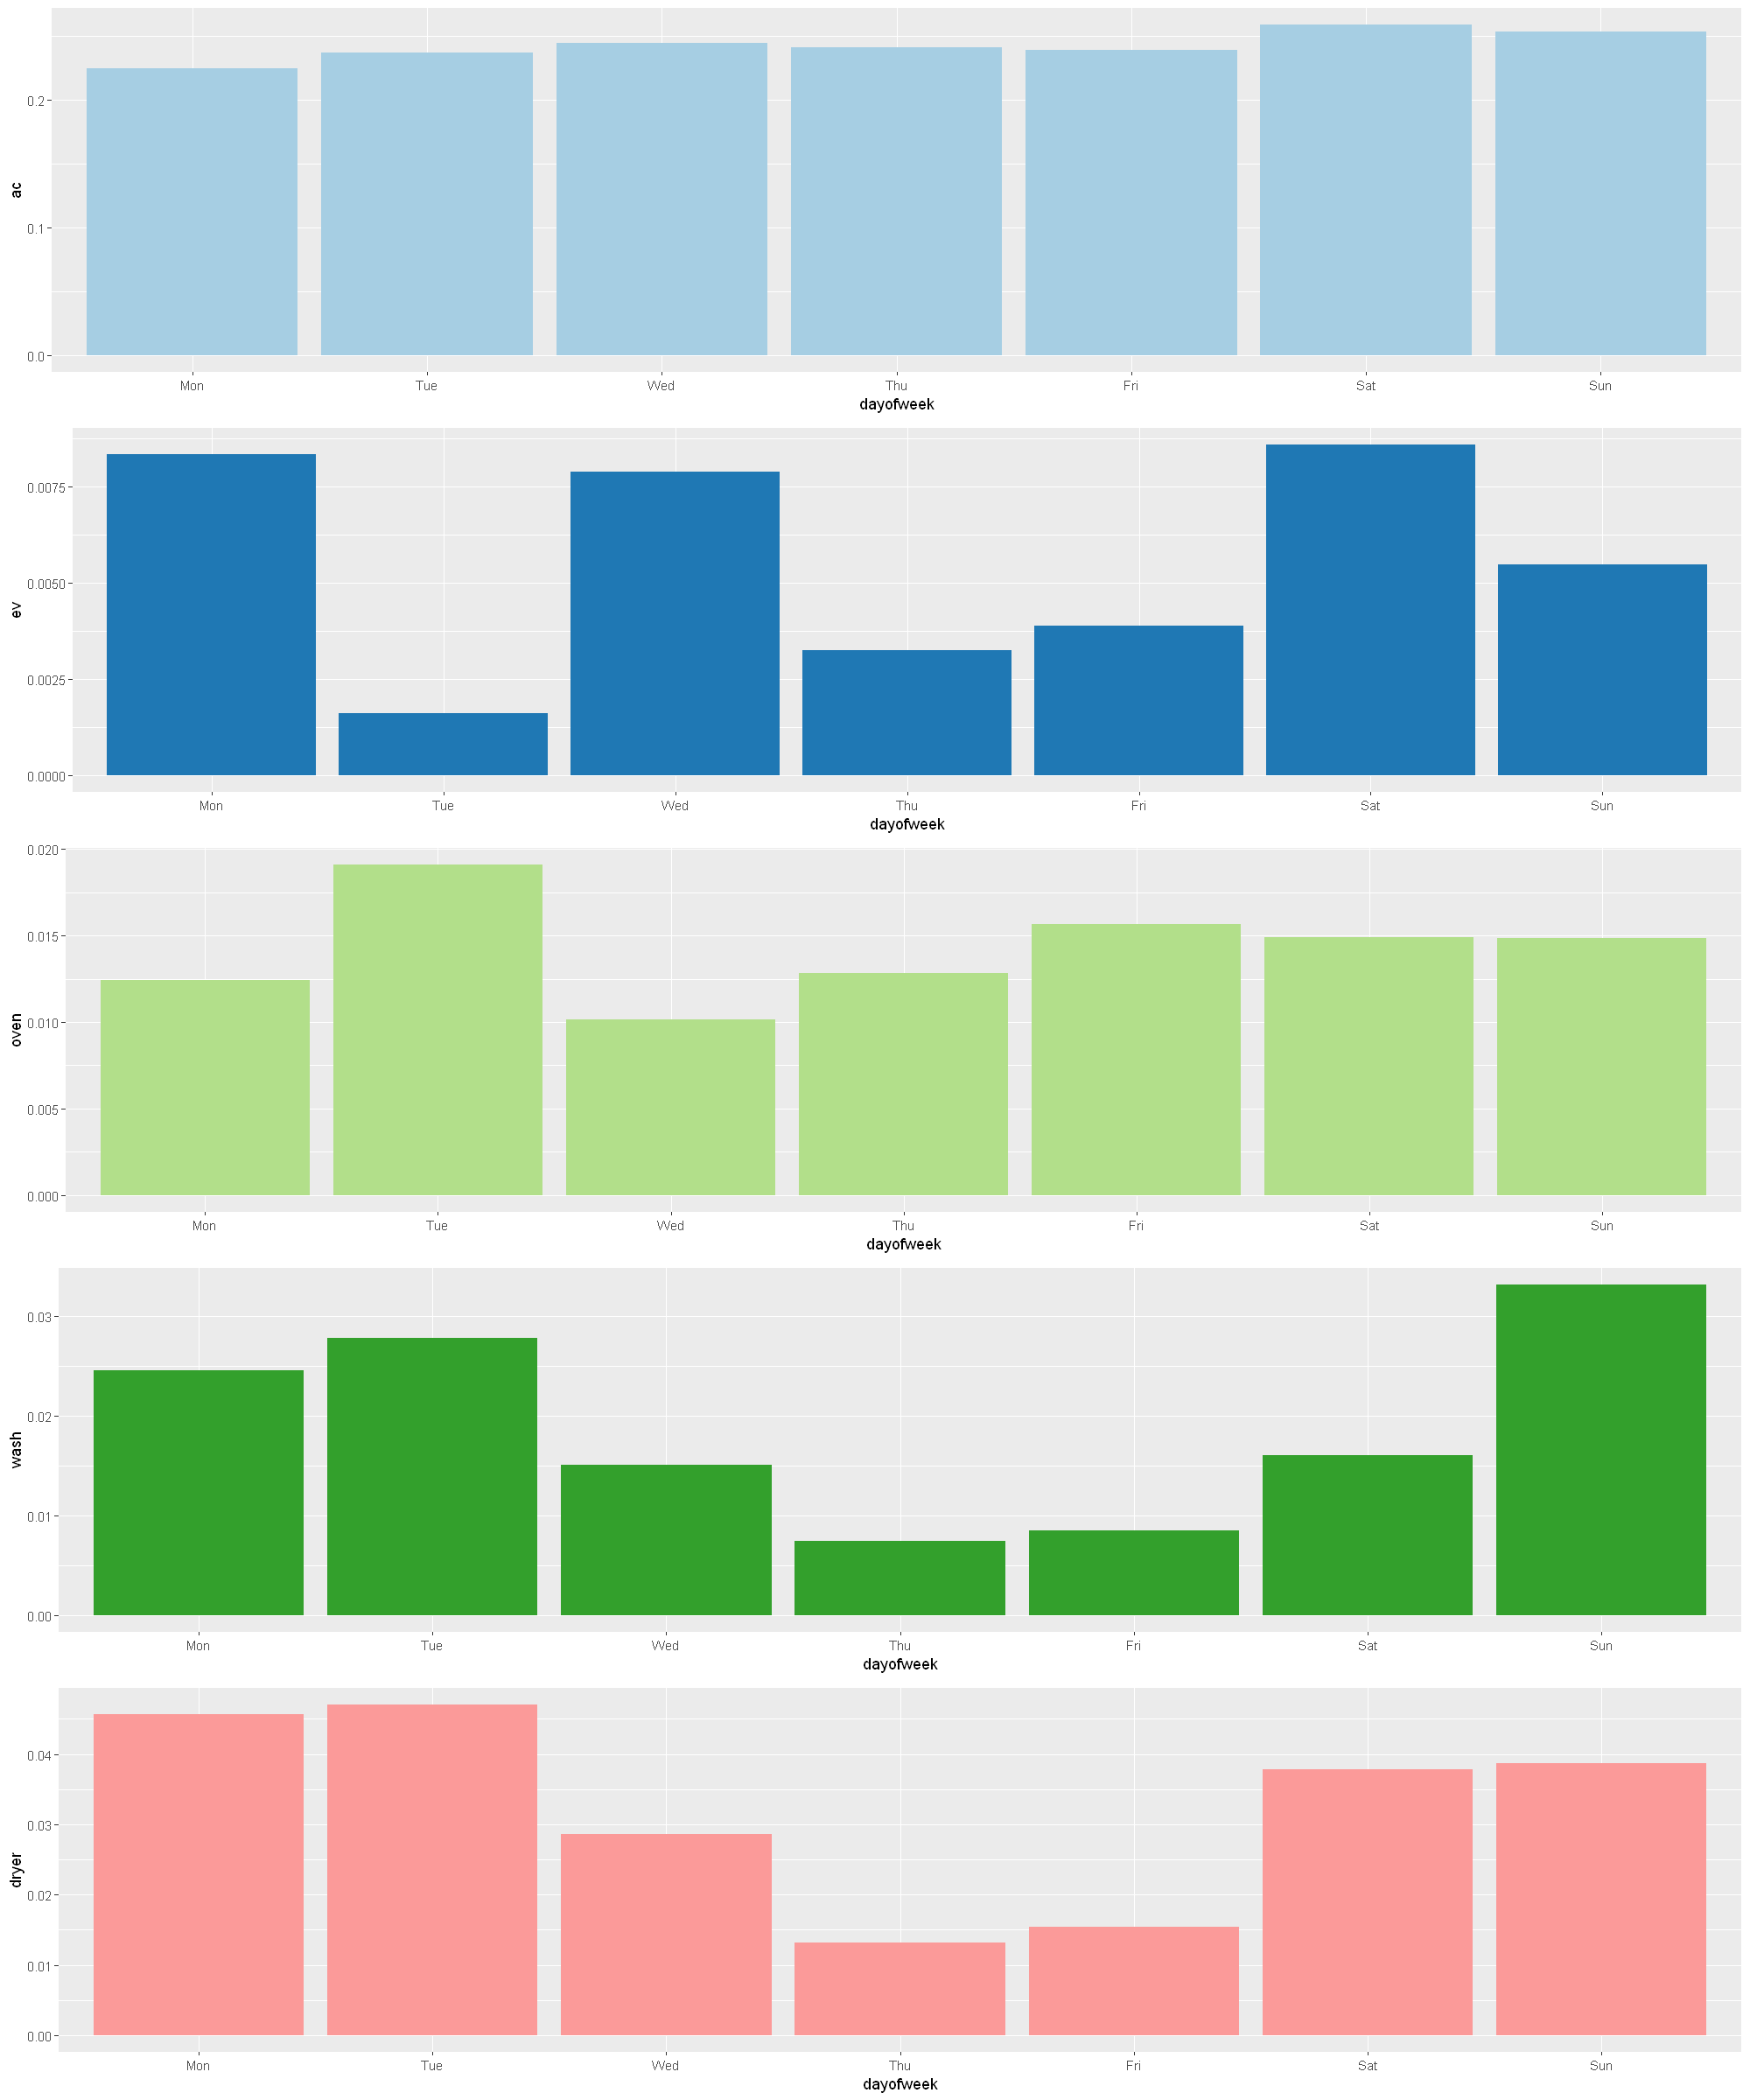

In [19]:
# Plot % usage by day of the week

# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 20)

p1 <-ggplot(dayofweek.agg, aes(x=dayofweek,y=ac)) +
    geom_col(fill='#a6cee3')

p2 <-ggplot(dayofweek.agg, aes(x=dayofweek,y=ev)) +
    geom_col(fill='#1f78b4')

p3 <-ggplot(dayofweek.agg, aes(x=dayofweek,y=oven)) +
    geom_col(fill='#b2df8a')

p4<-ggplot(dayofweek.agg, aes(x=dayofweek,y=wash)) +
    geom_col(fill='#33a02c')

p5<-ggplot(dayofweek.agg, aes(x=dayofweek,y=dryer)) +
    geom_col(fill='#fb9a99')

grid.arrange(p1, p2,p3, p4,p5 ,nrow = 5)

**Seasonal Analysis**

1. There were no significant differences in load among day of week
2. On average, people used more electricity in the evening and early night.
3. We used % usage of each target variable to find when people frequently used each appliance (both hour of day and day of week).
4. We found that each appliance had different peak hours meaning that this might be one of the selected features in model development part.
5. However, day of week had less impact on AC, while this showed patterns in other appliances.   

#### Quantitative Predictors :

In [20]:
options(warn = -1)

# Column names for quantitative predictors
quant.column <- colnames(train.data)[c(1,9:15)] 

quant.column

# # Training data with quantitative predictors
quant.data <- train.data %>%
                select(quant.column)

# head(quant.data)

[1] "load"      "dif"       "absdif"    "max"       "var"       "entropy"  
[7] "nonlinear" "hurst"

No id variables; using all as measure variables


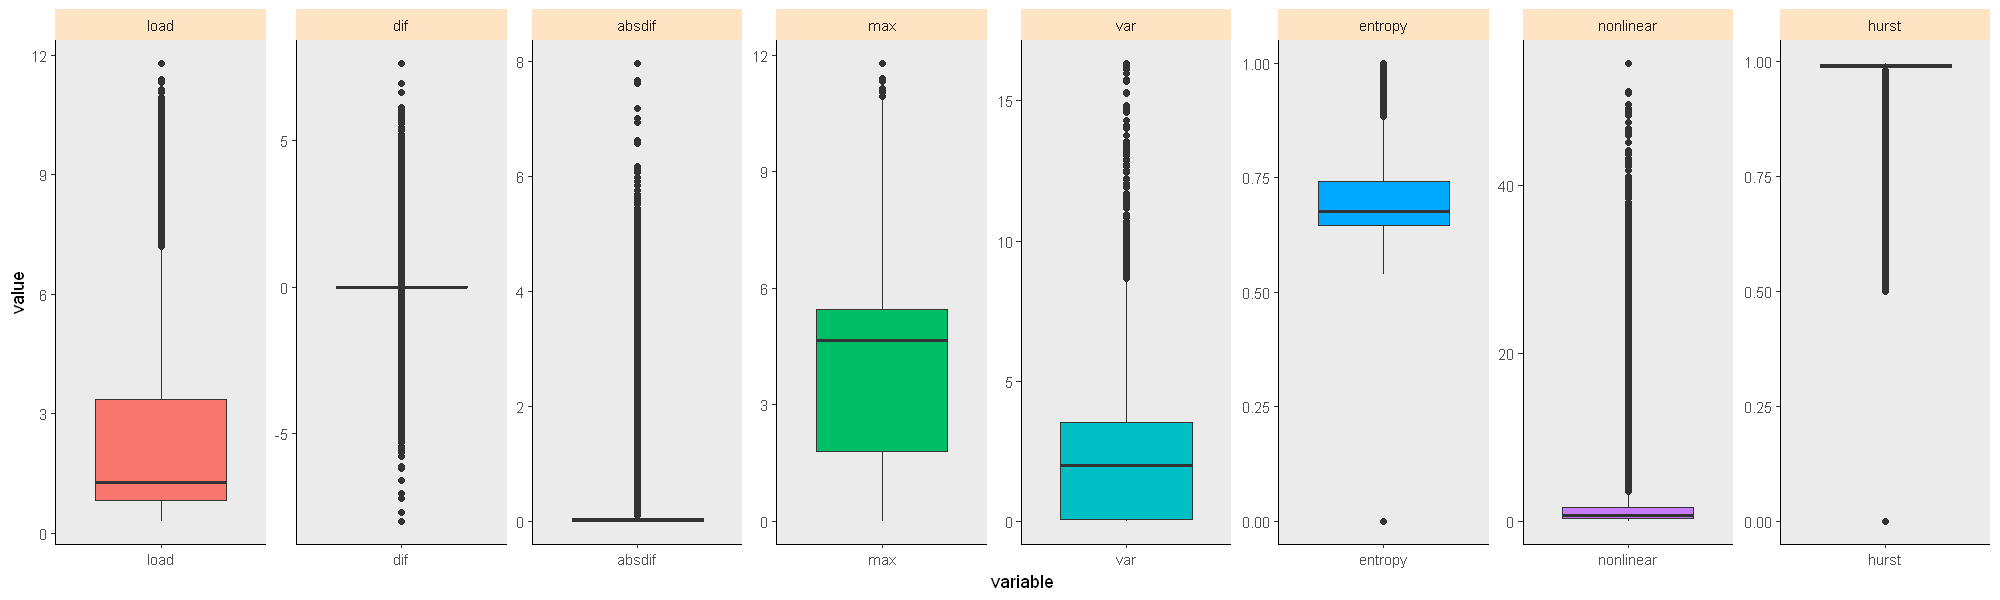

In [21]:
# Generate box plots for all numeric variables

# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 5)

# For better visualisation
m1 <- melt(as.data.frame(quant.data))

ggplot(m1,aes(x = variable,y = value)) +

facet_wrap(~variable, scales="free", nrow=1) +

theme(strip.background = element_rect(fill="bisque"), 
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      axis.line = element_line(colour = "black"),
      legend.position = "none") +

geom_boxplot(aes(fill = variable))

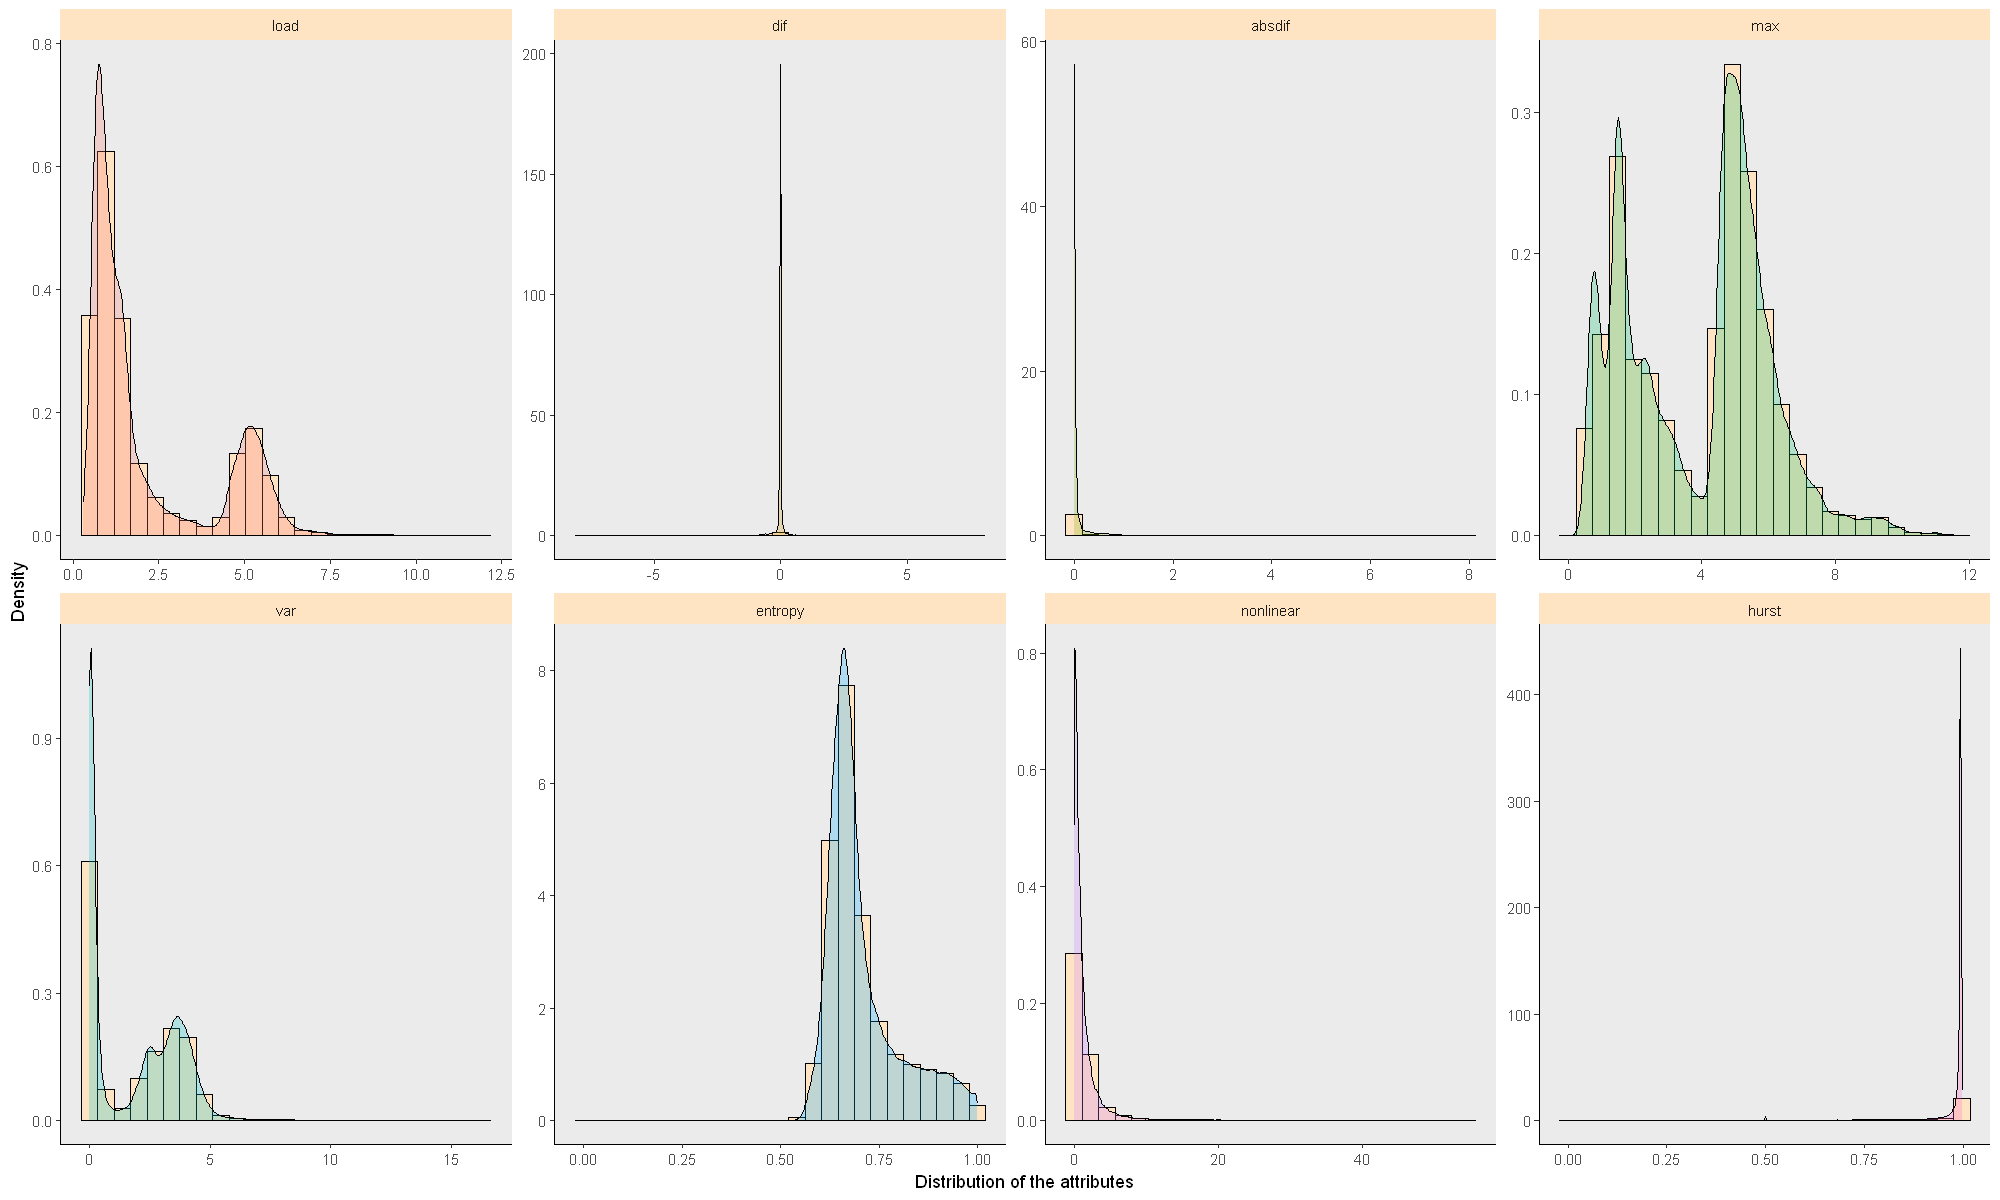

In [22]:
# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 10)

# Plot a histogram or bar chart of each variable
ggplot(m1,aes(x = value)) +
facet_wrap(~variable, scales="free", nrow=2) +
geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   bins=25,
                   colour="black", fill="bisque") +
labs(x="Distribution of the attributes" , 
                     y = "Density") +
theme(strip.background = element_rect(fill="bisque"), 
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      axis.line = element_line(colour = "black"),
      legend.position = "none") +
geom_density(alpha=.25, aes(fill = variable))


# Reference: http://www.cookbook-r.com/Graphs/Plotting_distributions_(ggplot2)/

**Observations for Boxplot and Histogram:**

1. Attributes `load` and `max` have extreme positive values confirming positive / right skewed distribution. `max` which indicates maximum load during last one hour exhibits similar distribution with offset. This is expected since underlying feature in this case is the load. 

2. Both `diff` and `absdiff` have 50% data at 0 which indicates that there is not much change between 2 sequential data points for most of the time.

3. Attributes `var` and `nonlinear` has extreme positive values confirming positive / right skewed distribution. Howvever 75% of the var attribute have values between 0 and 4. 

4. Since `hurst` indicates 0.5 + plus the MLE of the fractional differencing order, it is expected to see boxplot of hurst starting from 0.5.

##### Histogram of Target variables for each quantitative feature :

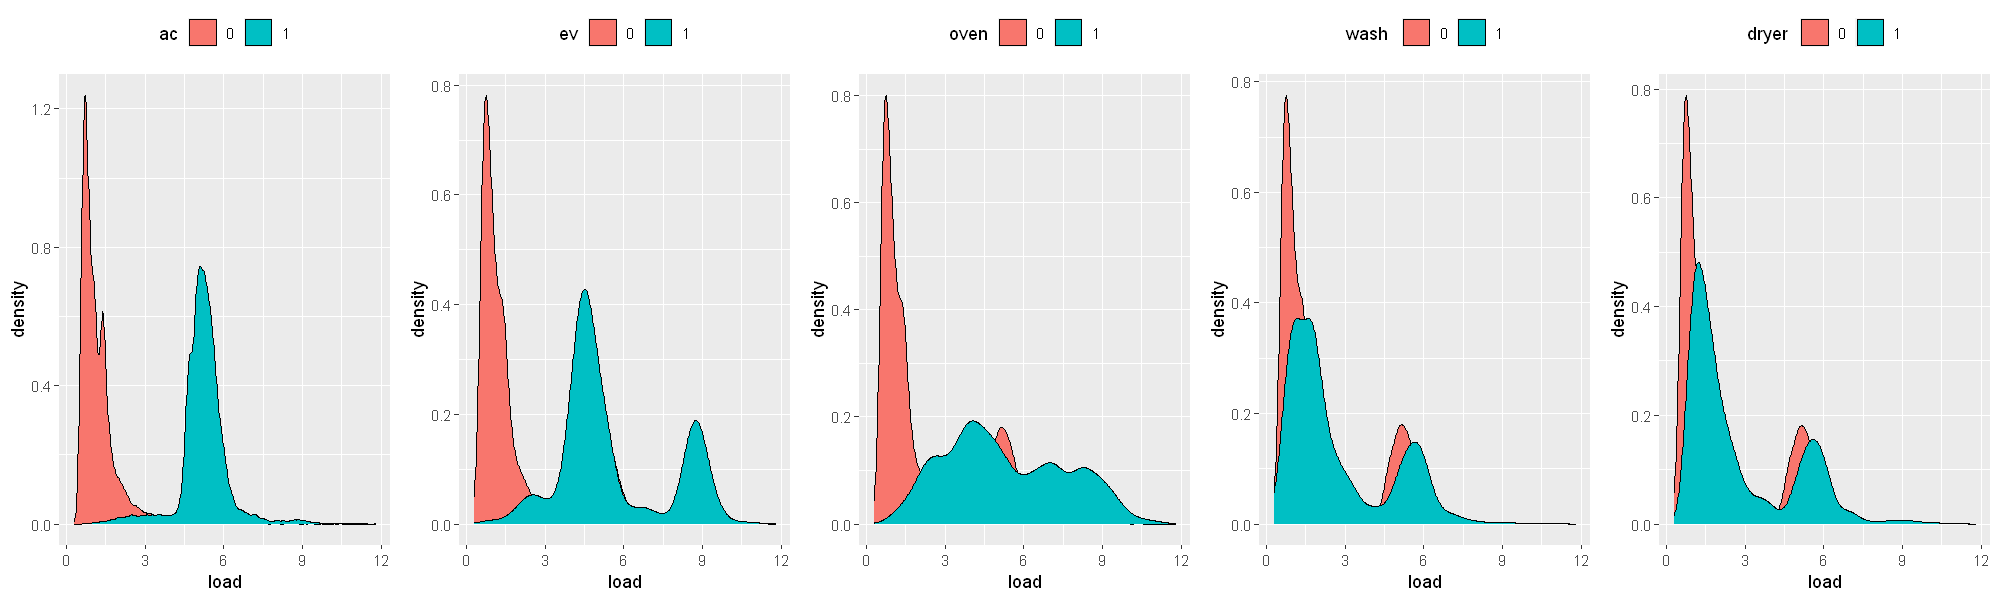

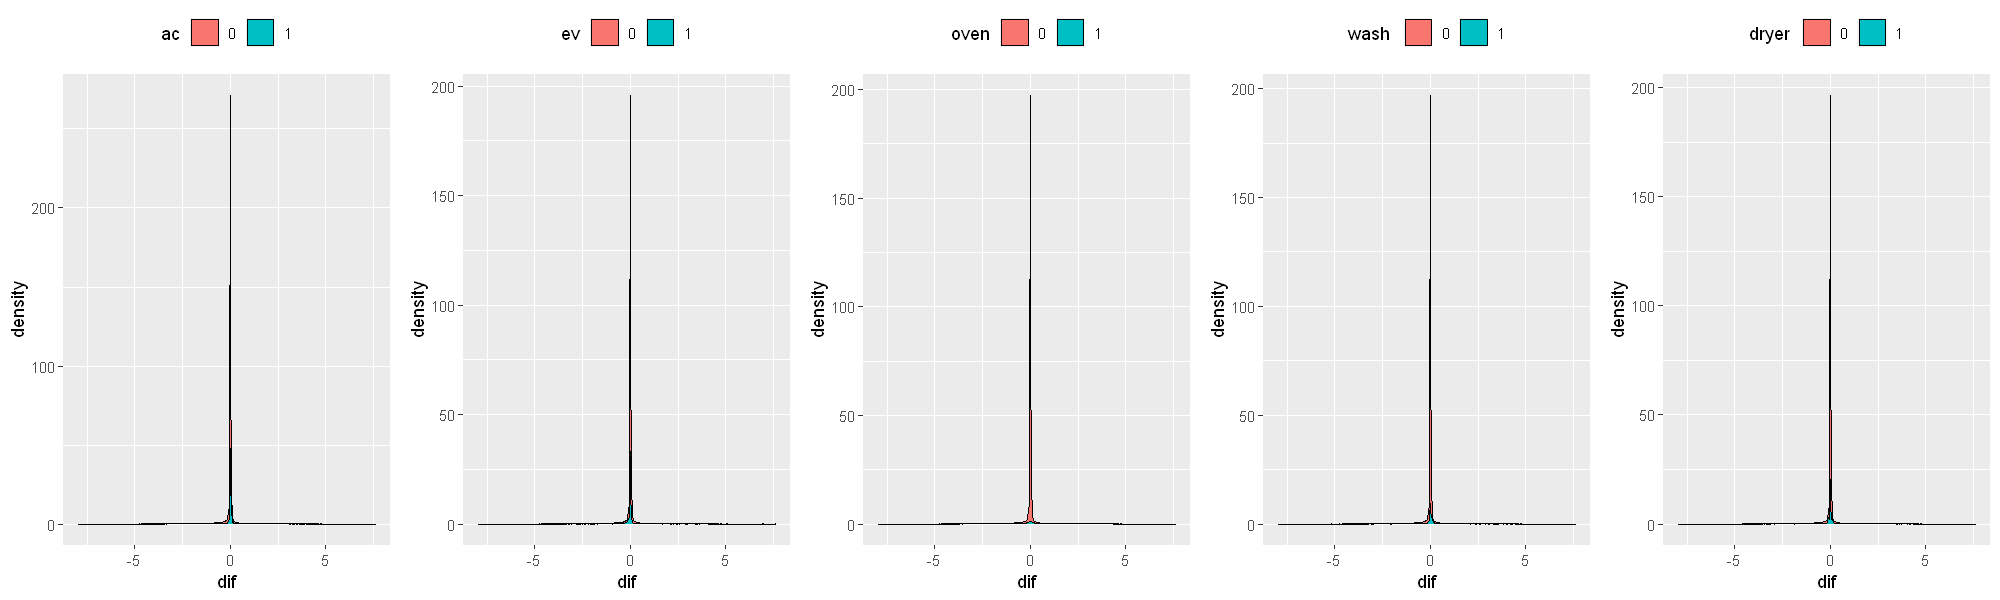

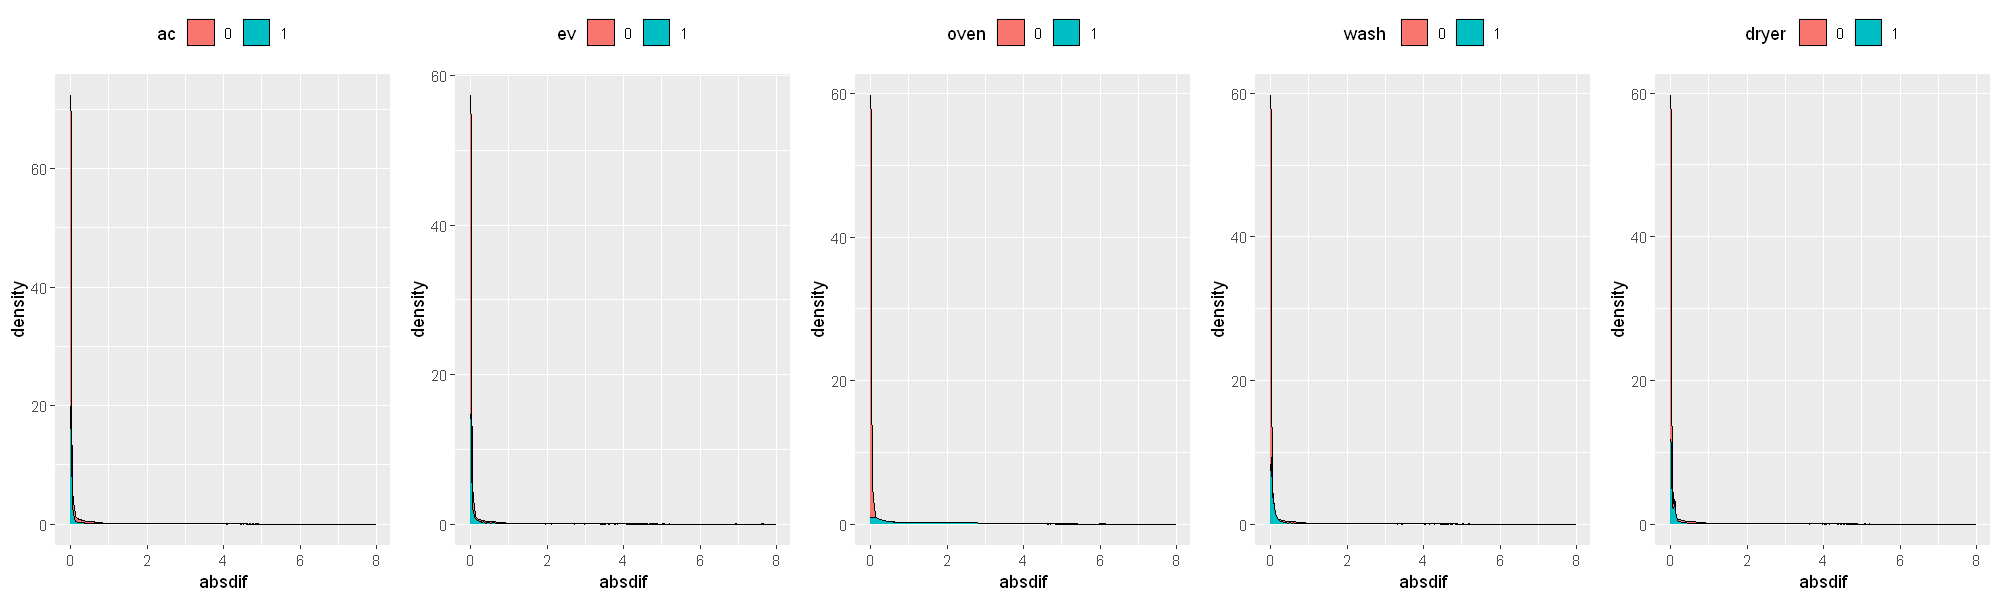

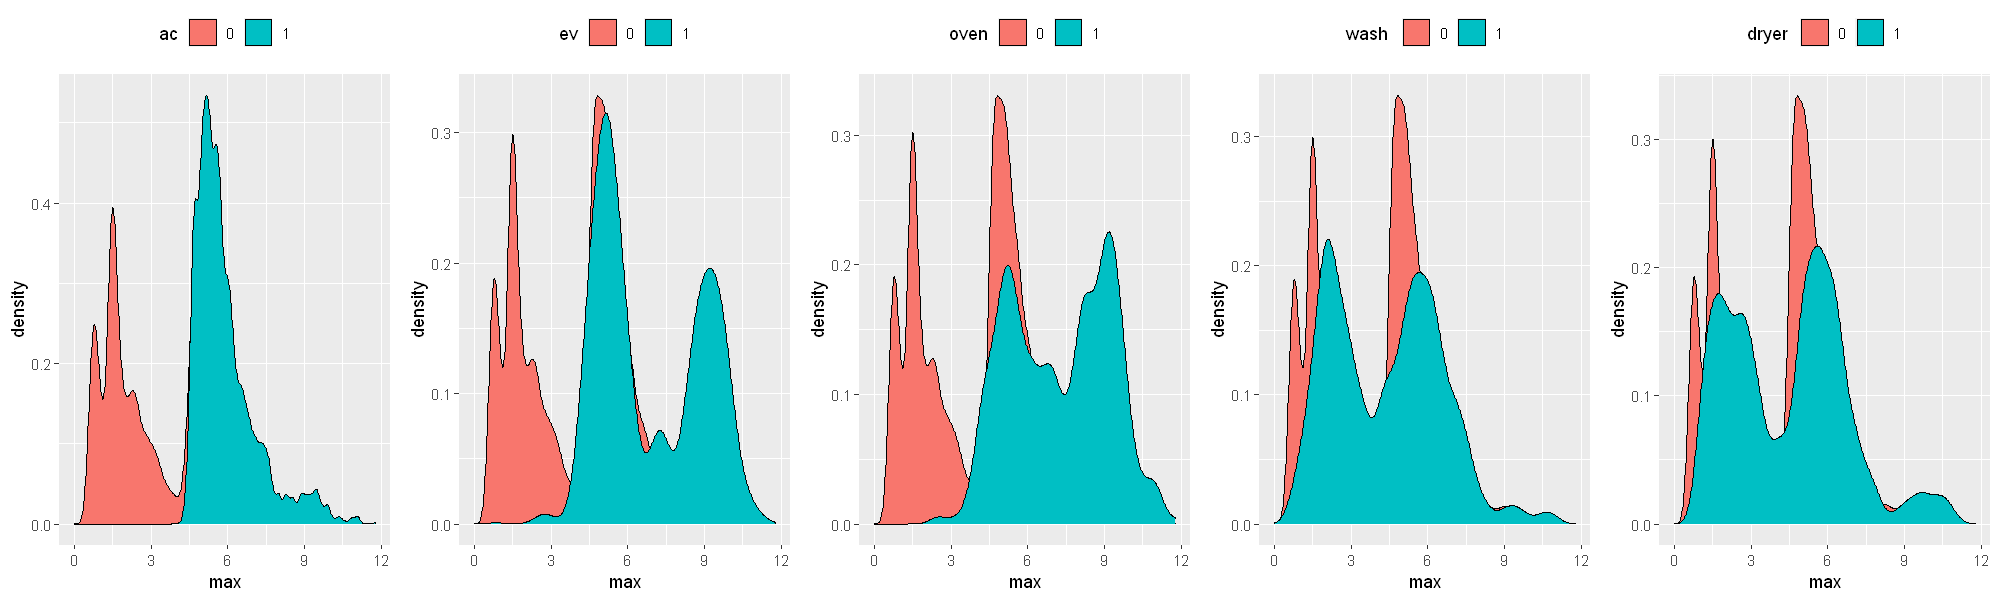

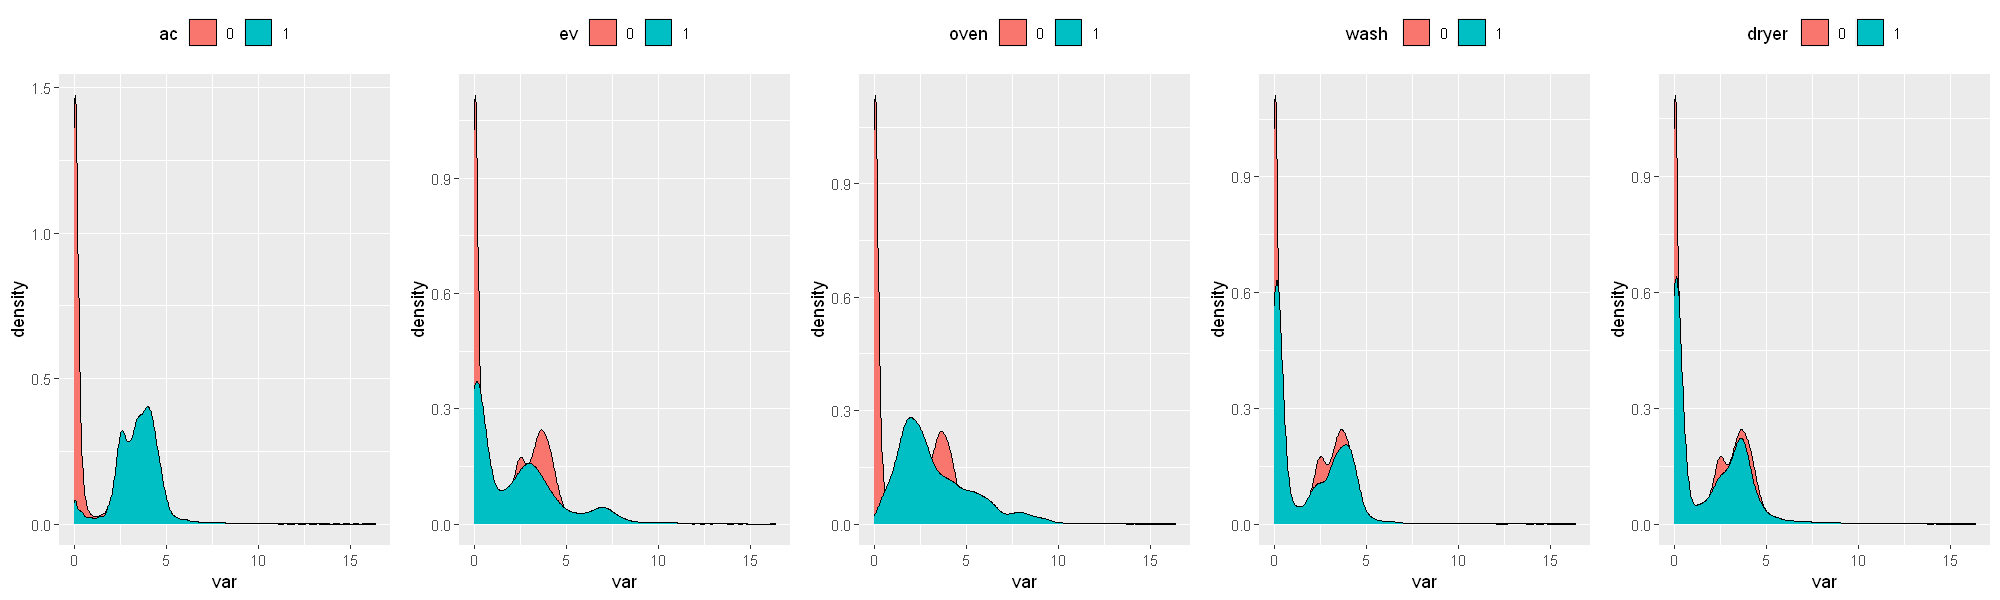

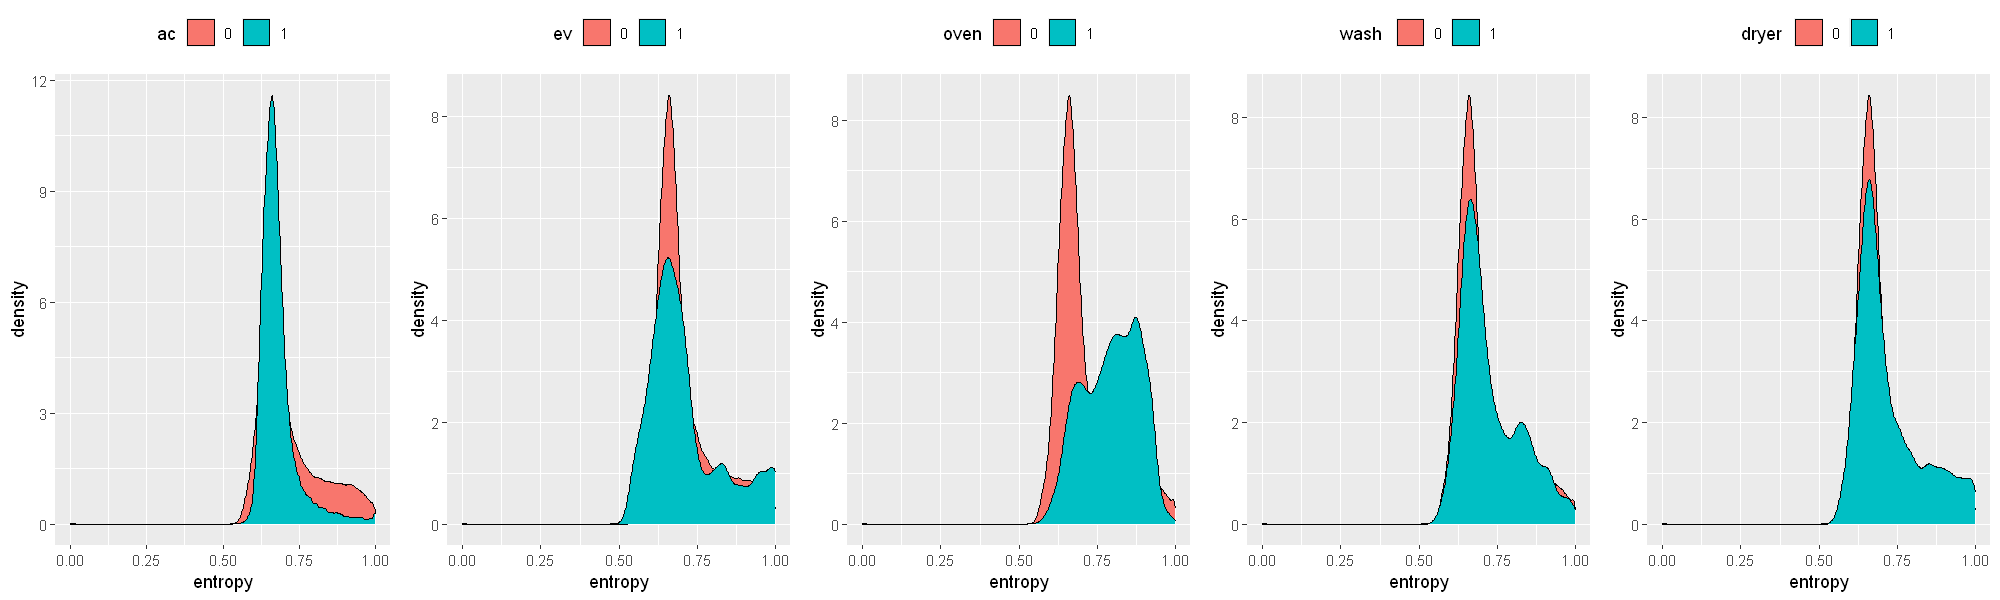

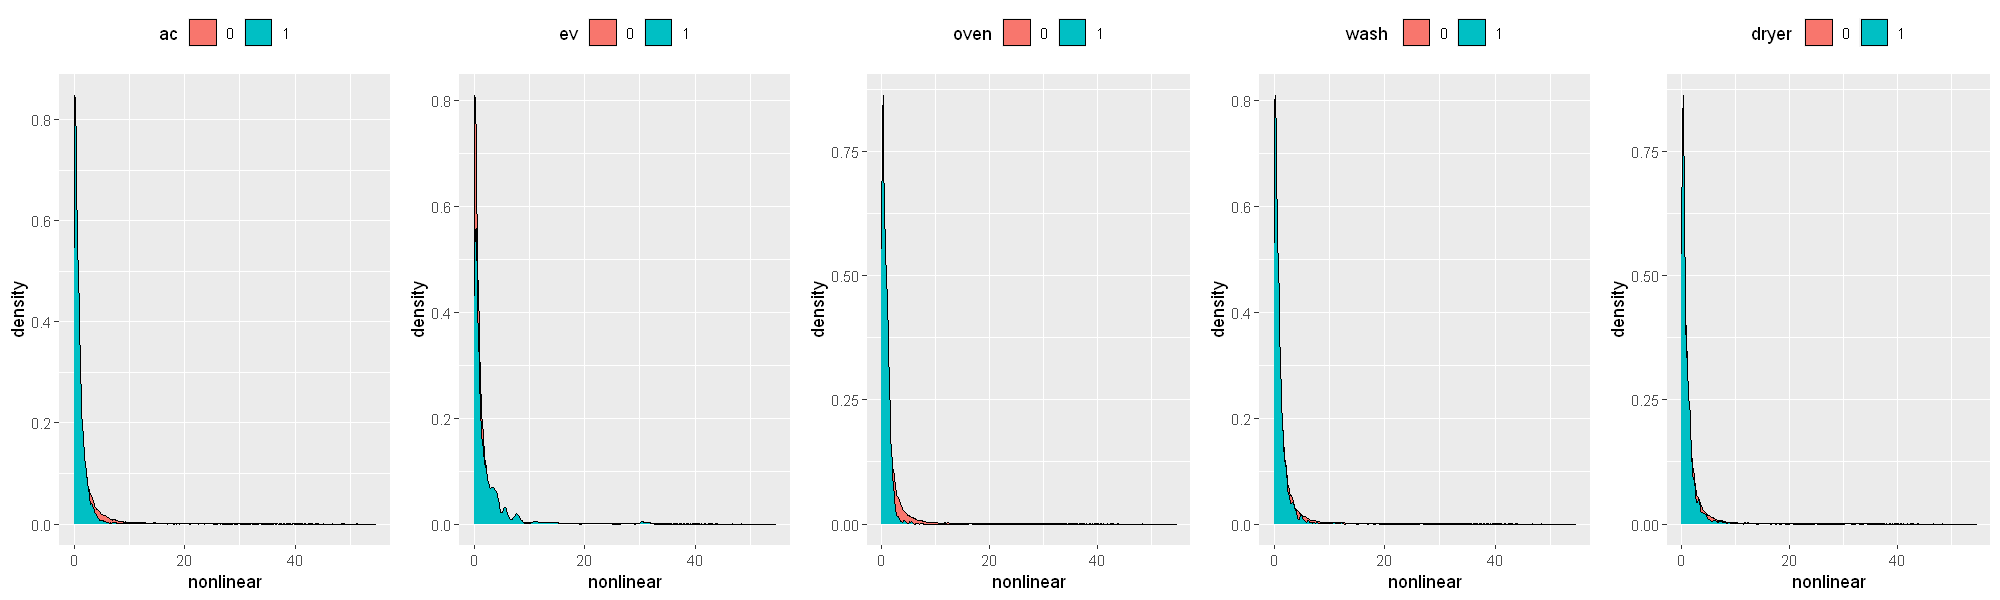

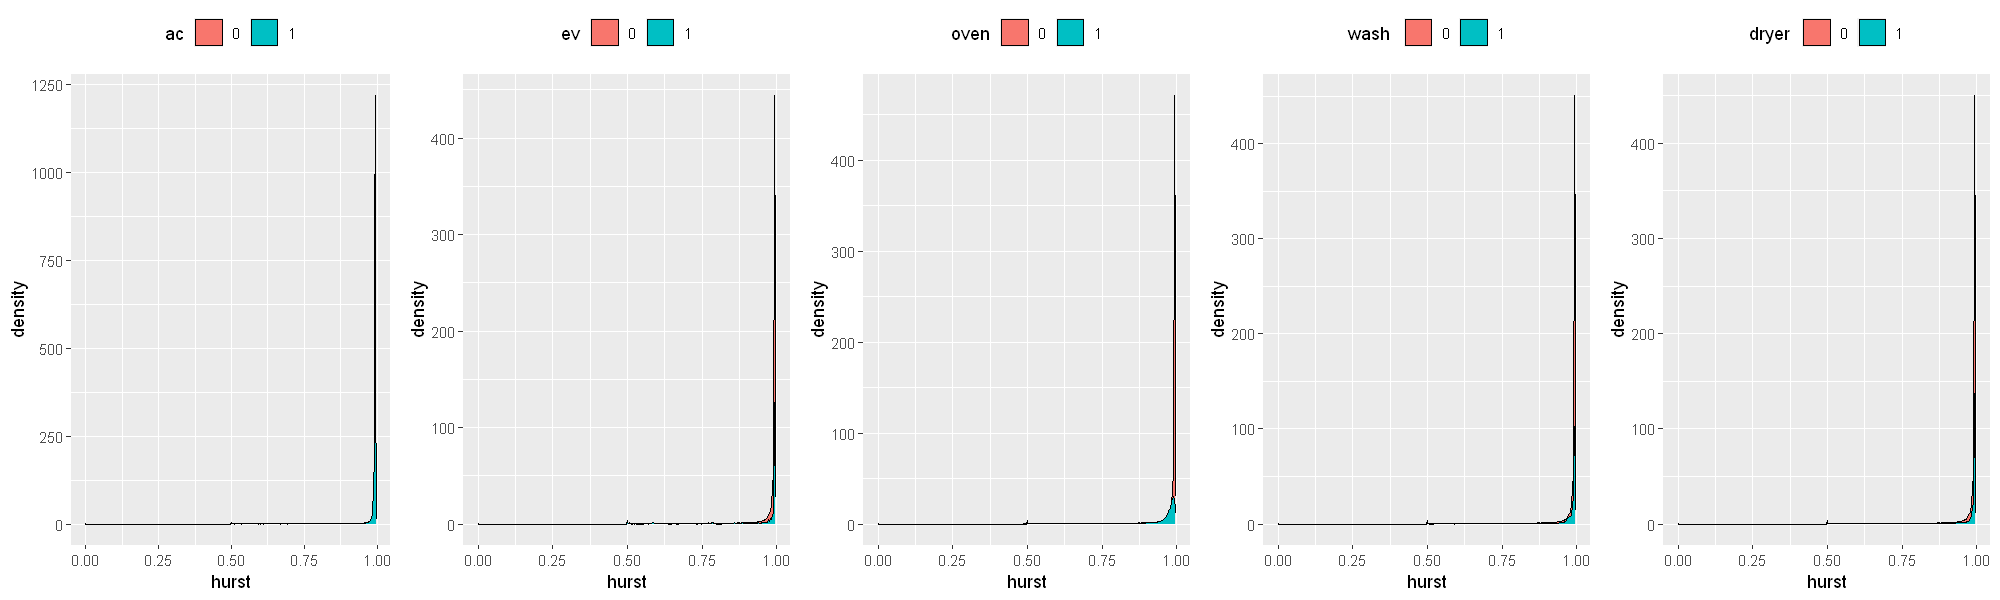

In [23]:
# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 5)

for(col in quant.column){
    p1<-ggplot(data=train.data,aes(x=train.data[,col] ))+
              geom_density(aes(fill = as.factor(ac)))+
              labs(fill = "ac",x =col)+
              theme(legend.position="top")

    p2<-ggplot(data=train.data,aes(x=train.data[,col] ))+
              geom_density(aes(fill = as.factor(ev)))+
              labs(fill = "ev",x =col)+
              theme(legend.position="top")

    p3<-ggplot(data=train.data,aes(x=train.data[,col] ))+
              geom_density(aes(fill = as.factor(oven)))+
              labs(fill = "oven",x =col)+
              theme(legend.position="top")

    p4<-ggplot(data=train.data,aes(x=train.data[,col] ))+
              geom_density(aes(fill = as.factor(wash)))+
              labs(fill = "wash",x =col)+
              theme(legend.position="top")

    p5<-ggplot(data=train.data,aes(x=train.data[,col] ))+
              geom_density(aes(fill = as.factor(dryer)))+
              labs(fill = "dryer",x =col)+
              theme(legend.position="top")
    
    grid.arrange(p1,p2,p3,p4,p5,nrow = 1)
}

**ANALYSIS**

* **Load** shows significance as the most important feature. The box plot and density plot of load for ON and OFF status for all target appliances varied significantly.

* **Diff & Abs diff** has maximum density at 0, indicating that most of the observations in the dataset are 0 (i.e. OFF state)

* Since **Max** indicates maximum value of the load for a given 60 minute window, its distribution resembles similar to that of Load.



---

## 4. Methodology<a class="anchor" id="sec_4"></a>

* Before the model development part, the experiment setups should be appropriately designed. In our case, we deal with classification of imbalance target variables. 

* Only a few records have on-status in each appliance (only 24 % for AC, 0.6 % for EV, 1.4 % for Oven, 1.9 % for Wash and 4.8 % for Dryer). This required the specialised approaches for experiments setup mainly divided into three sections, which are:
  1.   Metric Selection 
  2.   Validation approach
  3.   Hyperparameter Tuning 





---


## 5. Model Development <a class="anchor" id="sec_5"></a>

### 5.1 Define Model Evaluation Function

The evaluation metric used in test is the F1 score, which is defined as

<center>$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$</center>

where

<center>$Precision = \frac{True Positive}{TruePositive + False Positive}$</center>

and
<center>$Recall = \frac{True Positive}{TruePositive + False Negative}$</center>

In [24]:
# Use this function to check the performance of your model
func_eval <- function(pred.label, truth.label){
  
    print(paste("Accuracy : ",round(Accuracy(pred.label,truth.label),4)*100,'%'))
    
    if(length(unique(pred.label)) == 1)
    {
    print(paste("Precision : ",0))
    print(paste("Recall : ",0))
    print(paste("F1 Score : ",0))
    print(paste("AUC : ",0))

    } else{
    print(paste("Precision : ",round(Precision(pred.label,truth.label,positive = 1),4)*100,'%'))
    print(paste("Recall : ",round(Recall(pred.label,truth.label,positive = 1),4)*100,' %'))
    print(paste("F1 Score : ",round(F1_Score(pred.label,truth.label,positive = 1),4)*100,'%'))
    print(paste("AUC : ",round(AUC(pred.label,truth.label),4)*100,'%'))
        
    }
}

# Create placeholder to store model performance for final results
model_results = list()

### 5.2. Baseline Models

**This part is for reference, Uncomment the code if need to see model comparison**

#### 5.2.1 Data Preprocessing

##### One-hot Encoding

Redo some preprocessing from raw data to ensure that our original data aren't altered.

In [25]:
# X is a key, which does the same job as index. Hence, removing X from the training dataset.
train.data = select(dat_train, -c("X"))
test.data = select(dat_test, -c("X"))

In [26]:
# Encode 'Factors' predictor into one-hot embedding
train.data <- fastDummies::dummy_cols(train.data, remove_first_dummy = FALSE,remove_selected_columns = TRUE)
test.data <- fastDummies::dummy_cols(test.data, remove_first_dummy = FALSE,remove_selected_columns = TRUE)

In [27]:
# Preview data structure
head(train.data)
head(test.data)

load,ac,ev,oven,wash,dryer,hourofday,dif,absdif,max,...,entropy,nonlinear,hurst,dayofweek_Fri,dayofweek_Mon,dayofweek_Sat,dayofweek_Sun,dayofweek_Thu,dayofweek_Tue,dayofweek_Wed
2.245,0,0,0,0,0,0,0.987,0.987,6.215,...,0.6788858,0.05290291,0.9940715,0,0,0,1,0,0,0
2.259,0,0,0,0,0,0,0.014,0.014,6.215,...,0.6674503,0.05482926,0.9941540,0,0,0,1,0,0,0
2.269,0,0,0,0,0,0,0.010,0.010,6.215,...,0.6477770,0.05699074,0.9942200,0,0,0,1,0,0,0
2.268,0,0,0,0,0,0,-0.001,0.001,6.215,...,0.6292270,0.05760593,0.9941497,0,0,0,1,0,0,0
2.270,0,0,0,0,0,0,0.002,0.002,6.215,...,0.6212951,0.08263997,0.9940406,0,0,0,1,0,0,0
2.259,0,0,0,0,0,0,-0.011,0.011,6.215,...,0.6269564,0.08978753,0.9939864,0,0,0,1,0,0,0


load,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek_Fri,dayofweek_Mon,dayofweek_Sat,dayofweek_Sun,dayofweek_Thu,dayofweek_Tue,dayofweek_Wed
1.869,0,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0
1.673,0,-0.196,0.196,0,0,0,0,0,0,1,0,0,0,0,0
1.660,0,-0.013,0.013,0,0,0,0,0,0,1,0,0,0,0,0
1.772,0,0.112,0.112,0,0,0,0,0,0,1,0,0,0,0,0
1.679,0,-0.093,0.093,0,0,0,0,0,0,1,0,0,0,0,0
1.775,0,0.096,0.096,0,0,0,0,0,0,1,0,0,0,0,0


##### Train & Validation Dataset


Our given **test dataset** are unseen data with no label. Therefore, our best practice is to create a validation dataset to check our modeling performance. We'll be using 20% of train dataset as validation data. We will also be performing stratify sampling for each target variables so each targets model will be trained on different train data. Therefore, we cannot compare same model with different targets.

In [28]:
# Stratified Splitting (After we performed all Feature extraction, we could treat each role as independent when training the model)

all_train = list()
all_valid = list()

# Create Train/Test dataset for each "Target"
for(i in target.vector){
    
    set.seed(SEED_NUMBER)
    
    cat(i,"\n")
    
    inds <- partition(train.data[[i]], p = c(train = 0.8, valid = 0.2)) 
    
    train.set <- train.data[inds$train, ]
    valid.set <- train.data[inds$valid, ]
    
    all_train[[i]] = train.set
    all_valid[[i]] = valid.set
    
    cat("RAW ",train.data %>% filter(!!as.symbol(i) == 0) %>% count() %>% pull(), 
               train.data %>% filter(!!as.symbol(i) == 1) %>% count() %>% pull(),"\n")

    cat("Train ",train.set %>% filter(!!as.symbol(i) == 0) %>% count() %>% pull(),
                 train.set %>% filter(!!as.symbol(i) == 1) %>% count() %>% pull(),"\n")

    cat("Valid ",valid.set %>% filter(!!as.symbol(i) == 0) %>% count() %>% pull(),
                 valid.set %>% filter(!!as.symbol(i) == 1) %>% count() %>% pull(),"\n")
                 
    cat("\n")
}
# head(all_train$ac)

ac 
RAW  316521 101199 
Train  253216 80959 
Valid  63305 20240 

ev 
RAW  415385 2335 
Train  332308 1868 
Valid  83077 467 

oven 
RAW  411764 5956 
Train  329412 4764 
Valid  82352 1192 

wash 
RAW  409767 7953 
Train  327813 6362 
Valid  81954 1591 

dryer 
RAW  404144 13576 
Train  323316 10860 
Valid  80828 2716 



#### 5.2.2 Logistic Regression Model

In [29]:
# Create list to store logistic regression model for five different target variables
lr.list <- list()

build_logistic_reg <- function(targets){
    # Create xgboost model in each 
    for(target in targets){
        
        # Load train/validate dataset of each predictor
        train.set = all_train[[target]]
        valid.set = all_valid[[target]]
        
        # Create target label vector in each target
        train.label <-train.set[,target]
        valid.label <-valid.set[,target]
        
        # Generate glm formula
        glmFormula <- as.formula( paste(target,"~",". -", paste(target.vector[target.vector != target], collapse="-")))

        # Fit the linear regression model
        lr.fit <- glm(glmFormula,data = train.set ,family = binomial)   

        
        # Use stepwise to select features
    #     lr.step <- step(lr.fit,trace = 0)

        # Predict the label
        cat('\n',target,'\n')
        
        p <- predict(lr.fit,newdata = valid.set, type = "response" )
        pred.label <-as.integer( p >0.5)
        
        # Evaluate errors
        func_eval(pred.label,valid.label)
        print(table(pred.label,valid.label))
        
        # Store the model
        lr.list[[paste('lr',target,sep ='.')]] <<- lr.fit
    }
}

## Uncomment to see Base model performance
# build_logistic_reg(target.vector)

#### 5.2.3 SVM Model

Note: This code block takes 1.5-2 hours to run. Results are available in the report.

In [30]:
# Create list to store svm model for five different target variables
svm.list <- list()

# Create svm model for each target variable 
build_svm <- function(targets){
    for(target in targets){
        
        cat("Build SVM Model to predict target ", target, "\n")
        
        # Fix the seed of the random number generator to make the result repeatable.
        set.seed(SEED_NUMBER)
        
        # Load train/validate dataset of each predictor
        train.set = all_train[[target]]
        valid.set = all_valid[[target]]
        
        # Create target label vector in each target
        train.label <- as.factor(train.set[,target])
        valid.label <- as.factor(valid.set[,target])
        
        # Select features
        train.features <- train.set %>% select(-c(target.vector))
        valid.features <- valid.set %>% select(-c(target.vector))
        
        # Target variable
        cat('\n',target,'\n')
        
        # Build the model
        svm.fit = svm(train.label ~ . -ac-ev-oven-wash-dryer, data = train.set, kernel = 'linear')
        
        # Predict the target variable for valid set
        svm.pred  <- predict(svm.fit, valid.set)
        
        # Evaluate errors
        func_eval(svm.pred,valid.label)
        print(table(svm.pred,valid.label))
        
        # Store the model
        svm.list[[paste('svm', target, sep ='.')]] <<- svm.fit
        
        cat("=============================\n\n")

    }
}
## Uncomment to see Base model performance
# build_svm(target.vector)

#### 5.2.4 Random Forest

In [31]:
# Create list to store random forest model for five different target variables
rf.list <- list()

# Create random forest model for each target variable
build_rf <- function(targets){
    for(target in targets){
    
        cat("Build  Random Forest Model to predict target ", target, "\n")
        # Fix the seed of the random number generator to make the result repeatable.
        set.seed(SEED_NUMBER)
        
        # Load train/validate dataset of each predictor
        train.set = all_train[[target]]
        valid.set = all_valid[[target]]
        
        # Create target label vector in each target
        train.label <-as.factor(train.set[,target])
        valid.label <-as.factor(valid.set[,target])
        
        # Select features
        train.features <- train.set %>% select(-c(targets))
        valid.features <- valid.set %>% select(-c(targets))
        
        # Target variable
        cat('\n',target,'\n')
        
        # Build the model
        rf.fit = randomForest(x = train.features, y = train.label, data = train.set, ntree = 50, mtry = 6,importance =TRUE)

        # Predict the target variable for valid set
        rf.pred  <- predict(rf.fit, valid.set)
        
        # Evaluate errors
        func_eval(rf.pred,valid.label)
        print(table(rf.pred,valid.label))
        
        # Store the model
        rf.list[[paste('rf', target, sep ='.')]] <<- rf.fit
        
        cat("=============================\n\n")

    }
}

## Uncomment to see Base model performance
# build_rf(target.vector)

#### 5.2.5 Extreme Gradient Boosting (XGBoost)

In [32]:
# Create list to store xgboost model for five different target variables
xgboost.list <- list()

# Create xgboost model in each 
build_xgboost <- function(targets){
    for(target in targets){

        cat("Build Model xgBoost to predict target ", target, "\n")

        # Load train/validate dataset of each predictor
        train.set = all_train[[target]]
        valid.set = all_valid[[target]]
        
        # Create target label vector in each target
        train.label <-train.set[,target]
        valid.label <-valid.set[,target]
        
        # Select features
        train.features <- train.set %>% select(-c(targets))
        valid.features <- valid.set %>% select(-c(targets))
        
      
        # create DMatrix used for training xgboost
        train.matrix <- xgboost::xgb.DMatrix(data = as.matrix(train.features),label = train.label)    
        valid.matrix <- xgboost::xgb.DMatrix(data = as.matrix(valid.features),label = valid.label)
        
        # Count the number of instances in each class and will use in scale_pos_weight for imbalance data
        negative_instances <- sum(train.label == 0)
        positive_instances <- sum(train.label == 1)
        
        # Fix the seed of the random number generator to make the results repeatable
        set.seed(SEED_NUMBER)
        
        # Build the model
        xgb.fit <- xgboost::xgb.train(data =train.matrix,
                                      nrounds =1000,
                        
                        objective= "binary:logistic",
                        eval_metric ='auc',
                        early_stopping_rounds=20,
                        scale_pos_weight = negative_instances/positive_instances,
                        watchlist=list(val1=train.matrix,val2=valid.matrix),
                        verbose = 0)

        # Predict the label
        cat('\n',target,'\n')
        
        # Fix the seed of the random number generator
        set.seed(SEED_NUMBER)

        p <- predict(xgb.fit,valid.matrix)
        
        pred.label <-as.integer( p >0.5)
        
        # Evaluate errors
        func_eval(pred.label,valid.label)
        print(table(pred.label,valid.label))
        
        # Store the model
        xgboost.list[[paste('xgb',target,sep ='.')]] <<- xgb.fit

        # # Save Model Results
        
        # res[['algorithm']] = 'xgBoost'
        # res[['target']] = target
        # res[['F1Score']] = 0.5
        # model_results[['Test_model']] = res
        
        cat("=============================\n\n")
    }
}

## Uncomment to see Base model performance
# build_xgboost(target.vector)

### 5.3 Final Model with extracted features

Regard https://edstem.org/courses/5384/discussion/481603.

* Our group is aware of this discontinuity of time series data and understands that Feature extraction is no longer a requirement. However after additional investigation on the test dataset. 

* We notice that these anomalies are only a small portion of the test dataset. We consider this as **Noise-to-Signal** with a very low ratio and believe these noises are very minor to affect the model performance. 

* Moreover, we think that the tradeoff on what we could learn more on additional features can compensate for these errors. Therefore, we pursue more feature extraction from load data in time series.

#### 5.3.1 Data Preprocessing

##### One-hot Encoding + Feature Extraction

Redo some preprocessing from raw data to ensure that our original data aren't altered.

In [33]:
# X is a key, which does the same job as index. Hence, removing X from the training dataset.
train.data = select(dat_train, -c("X"))
test.data = select(dat_test, -c("X"))

In [34]:
# Encode 'Factors' predictor into one-hot embedding
train.data <- fastDummies::dummy_cols(train.data, remove_first_dummy = FALSE,remove_selected_columns = TRUE)
test.data <- fastDummies::dummy_cols(test.data, remove_first_dummy = FALSE,remove_selected_columns = TRUE)

In [35]:
# Extract features from data

# Reference: https://gist.github.com/drsimonj/2038ff9f9c67063f384f10fac95de566

# Set window size
window.size <- seq(2,30,2)


# Create new variable names

# name for rolling mean
rollmean_names <- paste("rollmean", formatC(window.size, width = nchar(max(window.size)), flag = "0"), 
  sep = "_")

# name for rolling max
rollmax_names <- paste("rollmax", formatC(window.size, width = nchar(max(window.size)), flag = "0"), 
  sep = "_")

# name for rolling variance
rollvar_names <- paste("rollvar", formatC(window.size, width = nchar(max(window.size)), flag = "0"), 
  sep = "_")

# Set name
rollingmean_functions <- setNames(paste("roll::roll_mean(., ", window.size, ")"), rollmean_names)
rollingmax_functions <- setNames(paste("roll::roll_max(., ", window.size, ")"), rollmax_names)
rollingvar_functions <- setNames(paste("roll::roll_var(., ", window.size, ")"), rollvar_names)

# Mutate new columns to training data
train.data <- train.data%>% 
                mutate_at(vars(load), funs_(rollingmean_functions)) %>%
                mutate_at(vars(load), funs_(rollingmax_functions)) %>%
                mutate_at(vars(load), funs_(rollingvar_functions)) %>%               
                na.omit()

# Mutate new features to testing data
test.data <- test.data%>% 
                mutate_at(vars(load), funs_(rollingmean_functions)) %>%
                mutate_at(vars(load), funs_(rollingmax_functions)) %>%
                mutate_at(vars(load), funs_(rollingvar_functions))%>%             
                na.omit()

# Note: Top 30 rows of the test data with NULL data have been omitted since they do not add any value.

In [36]:
# Preview data structure
head(train.data)
head(test.data)

,load,ac,ev,oven,wash,dryer,hourofday,dif,absdif,max,...,rollvar_12,rollvar_14,rollvar_16,rollvar_18,rollvar_20,rollvar_22,rollvar_24,rollvar_26,rollvar_28,rollvar_30
30,6.178,1,0,0,0,0,0,-0.021,0.021,6.215,...,3.6282741,3.573624,3.420348,3.250029,3.091089,2.948912,2.812171,2.678063,2.551239,2.435058
31,6.183,1,0,0,0,0,0,0.005,0.005,6.215,...,3.4638331,3.614486,3.568930,3.447470,3.316182,3.194715,3.072369,2.948162,2.823924,2.705839
32,6.155,1,0,0,0,0,0,-0.028,0.028,6.215,...,3.0828179,3.488350,3.592288,3.555953,3.469017,3.369728,3.270638,3.164204,3.050445,2.936768
33,6.143,1,0,0,0,0,0,-0.012,0.012,6.215,...,2.4894603,3.207334,3.499305,3.573554,3.544128,3.482085,3.413114,3.330160,3.234961,3.131528
34,5.419,1,0,0,0,0,0,-0.724,0.724,6.215,...,1.6560690,2.706782,3.191930,3.394336,3.446559,3.432336,3.391428,3.339176,3.270088,3.185722
35,4.915,1,0,0,0,0,0,-0.504,0.504,6.215,...,0.7454507,2.119357,2.795979,3.128995,3.266061,3.299255,3.292513,3.270923,3.228545,3.167806


,load,hourofday,dif,absdif,max,var,entropy,nonlinear,hurst,dayofweek_Fri,...,rollvar_12,rollvar_14,rollvar_16,rollvar_18,rollvar_20,rollvar_22,rollvar_24,rollvar_26,rollvar_28,rollvar_30
30,2.969,0,-0.088,0.088,0.000,0.0000000,0.0000000,0.0000000,0.0000000,0,...,0.008163606,0.009528071,0.009533467,0.174567203,0.259383853,0.30318960,0.3344115,0.3531991,0.3643686,0.3652040
31,2.994,0,0.025,0.025,3.148,0.4402283,0.6962088,0.4409098,0.9918233,0,...,0.009071114,0.010110797,0.008970729,0.097828118,0.209417779,0.28138997,0.3172356,0.3385541,0.3550023,0.3695941
32,3.027,0,0.033,0.033,3.148,0.4459753,0.6968304,0.3871768,0.9919481,0,...,0.010638152,0.009293874,0.009852250,0.009574997,0.161863187,0.24520984,0.2915189,0.3261265,0.3486327,0.3634093
33,3.028,0,0.001,0.001,3.148,0.4440533,0.6877399,0.3833629,0.9918300,0,...,0.011860992,0.010159670,0.010695583,0.009508771,0.090813839,0.19723432,0.2692353,0.3078471,0.3325428,0.3523143
34,3.030,0,0.002,0.002,3.148,0.4435435,0.6742414,0.4121860,0.9918215,0,...,0.012009970,0.011156571,0.010111896,0.010189765,0.009733292,0.15135817,0.2328401,0.2807172,0.3178066,0.3432596
35,3.148,0,0.118,0.118,3.148,0.4451218,0.6642380,0.3905114,0.9918004,0,...,0.015955295,0.014614071,0.013013267,0.013017477,0.011651674,0.08703876,0.1892614,0.2611128,0.3018863,0.3293480


##### Train & Validation Dataset


Our given **test dataset** are unseen data with no label. Therefore, our best practice is to create a validation dataset to check our modeling performance. We'll be using 20% of train dataset as validation data. We will also be performing stratify sampling for each target variables so each targets model will be trained on different train data. Therefore, we cannot compare same model with different targets.

In [37]:
# Stratified Splitting (After we performed all Feature extraction, we could treat each role as independent when training the model)

all_train = list()
all_valid = list()

# Create Train/Test dataset for each "Target"
for(i in target.vector){
    
    set.seed(SEED_NUMBER)
    
    cat(i,"\n")
    
    inds <- partition(train.data[[i]], p = c(train = 0.8, valid = 0.2)) 
    
    train.set <- train.data[inds$train, ]
    valid.set <- train.data[inds$valid, ]
    
    # print(train.set)
    all_train[[i]] = train.set
    all_valid[[i]] = valid.set
    
    cat("RAW ",train.data %>% filter(!!as.symbol(i) == 0) %>% count() %>% pull(), 
               train.data %>% filter(!!as.symbol(i) == 1) %>% count() %>% pull(),"\n")

    cat("Train ",train.set %>% filter(!!as.symbol(i) == 0) %>% count() %>% pull(),
                 train.set %>% filter(!!as.symbol(i) == 1) %>% count() %>% pull(),"\n")

    cat("Valid ",valid.set %>% filter(!!as.symbol(i) == 0) %>% count() %>% pull(),
                 valid.set %>% filter(!!as.symbol(i) == 1) %>% count() %>% pull(),"\n")
                 
    cat("\n")
}
# head(all_train$ac)

ac 
RAW  316498 101193 
Train  253198 80954 
Valid  63300 20239 

ev 
RAW  415356 2335 
Train  332284 1868 
Valid  83072 467 

oven 
RAW  411735 5956 
Train  329388 4764 
Valid  82347 1192 

wash 
RAW  409738 7953 
Train  327790 6362 
Valid  81948 1591 

dryer 
RAW  404115 13576 
Train  323292 10860 
Valid  80823 2716 



#### 5.3.2 XGBoost for extracted features

We try to tune our XGBoost model for each target variable by setting different parameters.

Note: This code block will take some time to run

In [38]:
# Defined parameters from Fined Tuned
target.params = list()
target.params$ac = list(eta=0.2, 
                        gamma=0.1, 
                        max_depth=6,
                        min_child_weight=1,
                        subsample=0.5, 
                        colsample_bytree=1, 
                        colsample_bylevel = 2/3)
target.params$ev = list( 
                        eta=0.1, 
                        colsample_bylevel = 2/3,
                        subsample=0.75,
                        max_depth=6,
                        min_child_weight=1,
                        gamma=0.1)
target.params$oven = list( 
                        eta=0.3, 
                        colsample_bylevel = 1,
                        subsample=1,
                        max_depth=6,
                        min_child_weight=1,
                        gamma=0)
target.params$wash = list( 
                        eta =0.3,
                        gamma=0.1, 
                        max_depth=6,
                        min_child_weight=1,
                        subsample=0.75, 
                        colsample_bytree=1)
target.params$dryer = list( 
                        eta =0.3,
                        gamma=0.1, 
                        max_depth=6,
                        min_child_weight=1,
                        subsample=0.75, 
                        colsample_bytree=1)

# print(paste(target.params,collapse=", "))

target.params2 = list()
target.params2$ac = list(
                          nrounds=500,
                          eval_metric = 'error',
                          early_stopping_rounds = NULL,
                          seed = 1)
target.params2$ev = list( 
                          nrounds=1000,
                          eval_metric = 'error',
                          early_stopping_rounds = 20,
                          seed = 1)
target.params2$oven = list(
                          nrounds=1000,
                          eval_metric = 'auc',
                          early_stopping_rounds = 20,
                          seed = 555)
target.params2$wash = list(
                          nrounds=1000,
                          eval_metric = 'error',
                          early_stopping_rounds = 20,
                          seed = 1)
target.params2$dryer = list(
                          nrounds=1000,
                          eval_metric = 'error',
                          early_stopping_rounds = 20,
                          seed = 1)
                          
# print(paste(target.params2,collapse=", "))

In [39]:
# Create list to store xgboost model for five different target variables
xgboost.list <- list()

# Create xgboost model in each 
build_xgboost_tuned <- function(targets,params,params2){
    for(target in targets){

        cat("Build Model xgBoost to predict target ", target, "\n")
        print("parameter:")
        print(paste(params[[target]],collapse=", "))
        print(paste(params2[[target]],collapse=", "))

        # print(params2[[target]]$early_stopping_rounds)
        
        # Load train/validate dataset of each predictor
        train.set = all_train[[target]]
        valid.set = all_valid[[target]]
        
        # Create target label vector in each target
        train.label <-train.set[,target]
        valid.label <-valid.set[,target]
        
        # Select features
        train.features <- train.set %>% select(-c(target.vector))
        valid.features <- valid.set %>% select(-c(target.vector))
        
      
        # create DMatrix used for training xgboost
        train.matrix <- xgboost::xgb.DMatrix(data = as.matrix(train.features),label = train.label)    
        valid.matrix <- xgboost::xgb.DMatrix(data = as.matrix(valid.features),label = valid.label)
        
        # Count the number of instances in each class and will use in scale_pos_weight for imbalance data
        negative_instances <- sum(train.label == 0)
        positive_instances <- sum(train.label == 1)
        
        set.seed(params2[[target]]$seed)
        xgb.fit <- xgboost::xgb.train(data =train.matrix,
                                      params = params[[target]],
                                      nrounds = params2[[target]]$nrounds,
                                      objective= "binary:logistic",
                                      eval_metric = params2[[target]]$eval_metric,
                                      scale_pos_weight = negative_instances/positive_instances,
                                      early_stopping_rounds= params2[[target]]$early_stopping_rounds,
                                      watchlist=list(val1=train.matrix,val2=valid.matrix),
                                      verbose = 0)

        # Predict the label
        cat('\n',target,'\n')
        
        p <- predict(xgb.fit,valid.matrix)
        pred.label <-as.integer( p >0.5)
        
        # Evaluate errors
        func_eval(pred.label,valid.label)
        print(table(pred.label,valid.label))
        
        # Store the model
        xgboost.list[[paste('xgb',target,sep ='.')]] <<- xgb.fit
    
        cat("=============================\n\n")
    }
}

## Build final model
build_xgboost_tuned(target.vector,target.params,target.params2)

Build Model xgBoost to predict target  ac 
[1] "parameter:"
[1] "0.2, 0.1, 6, 1, 0.5, 1, 0.666666666666667"
[1] "500, error, NULL, 1"

 ac 
[1] "Accuracy :  99.73 %"
[1] "Precision :  99.58 %"
[1] "Recall :  99.31  %"
[1] "F1 Score :  99.44 %"
[1] "AUC :  99.68 %"
          valid.label
pred.label     0     1
         0 63160    85
         1   140 20154

Build Model xgBoost to predict target  ev 
[1] "parameter:"
[1] "0.1, 0.666666666666667, 0.75, 6, 1, 0.1"
[1] "1000, error, 20, 1"

 ev 
[1] "Accuracy :  99.98 %"
[1] "Precision :  98.5 %"
[1] "Recall :  98.71  %"
[1] "F1 Score :  98.61 %"
[1] "AUC :  99.25 %"
          valid.label
pred.label     0     1
         0 83066     7
         1     6   460

Build Model xgBoost to predict target  oven 
[1] "parameter:"
[1] "0.3, 1, 1, 6, 1, 0"
[1] "1000, auc, 20, 555"

 oven 
[1] "Accuracy :  99.82 %"
[1] "Precision :  96.22 %"
[1] "Recall :  91.47  %"
[1] "F1 Score :  93.79 %"
[1] "AUC :  98.05 %"
          valid.label
pred.label     0     1


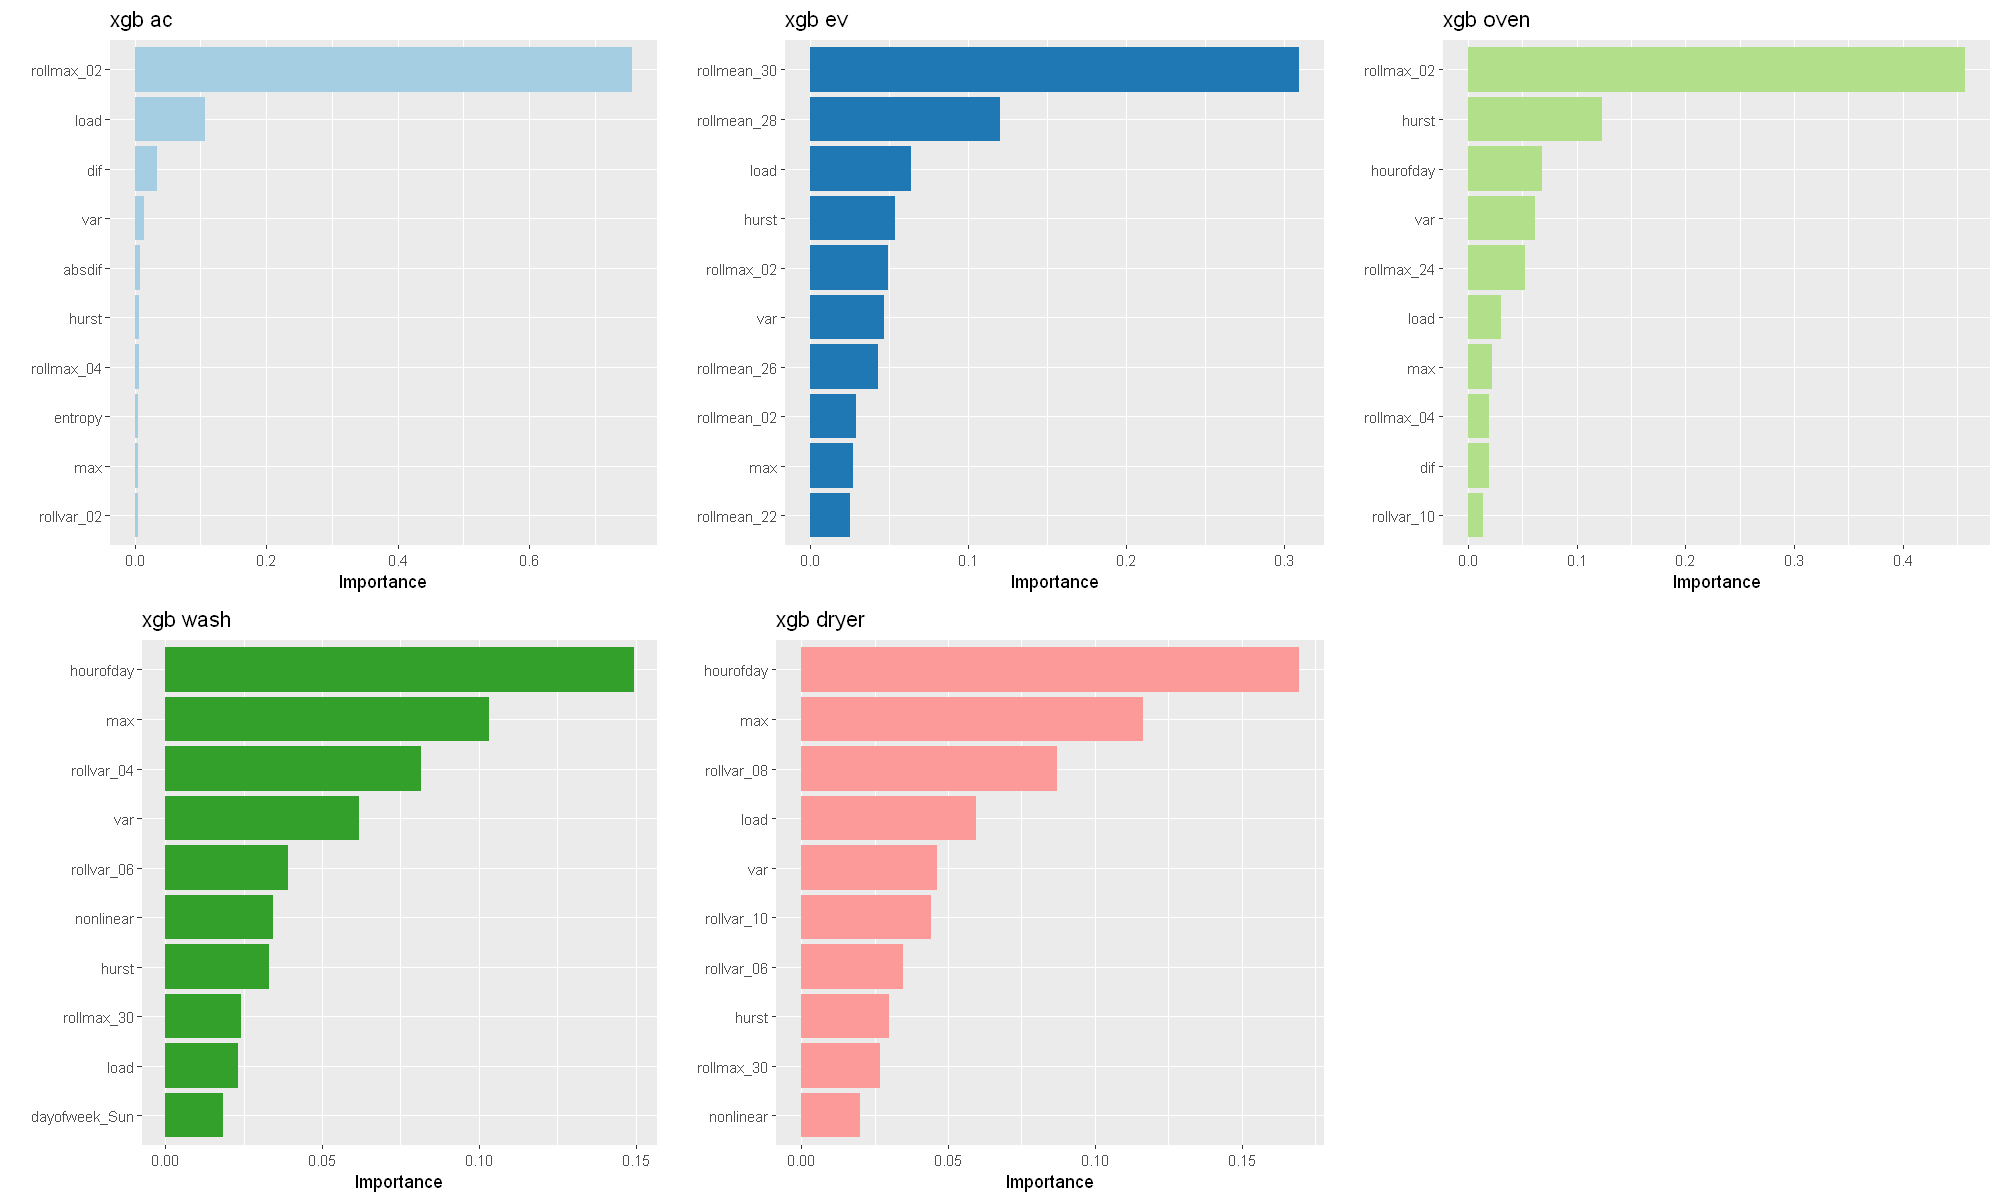

In [40]:
# Plot importance features

# Set plotting area
options(repr.plot.width=1200/72, repr.plot.height = 10)

imp1 <- vip::vi(xgboost.list$xgb.ac)
p1  <- vip::vip(imp1)+ 
        ggtitle("xgb ac")+
        geom_col(fill='#a6cee3')

imp2 <- vip::vi(xgboost.list$xgb.ev)
p2  <- vip::vip(imp2)+ 
        ggtitle("xgb ev")+
        geom_col(fill='#1f78b4')

imp3 <- vip::vi(xgboost.list$xgb.oven)
p3  <- vip::vip(imp3)+ ggtitle("xgb oven")+
        geom_col(fill='#b2df8a')

imp4 <- vip::vi(xgboost.list$xgb.wash)
p4  <- vip::vip(imp4)+ ggtitle("xgb wash")+
        geom_col(fill='#33a02c')

imp5 <- vip::vi(xgboost.list$xgb.dryer)
p5  <- vip::vip(imp5)+ ggtitle("xgb dryer")+
        geom_col(fill='#fb9a99')

grid.arrange(p1, p2, p3 ,p4,p5,ncol = 3)

* **Load and its derived rolling features** contribute a lot to the models especially in predicting AC. Rolling max (window size =2)  alone had around 80% importance for AC, while other models used combinations including load and time-related features. 

* An Alternative way to calculate this is the use of SHAP values, which also identify the importance of each feature in terms of SHAP values which correlates with the Importance values of different features. 

* Intuitively, AC patterns can be easily captured by any models using load, while others require more complexity to create accurate models.

### 5.4 Final Prediction and Export output

In [41]:
# Impute first 30 rows with 0
imputed_rows <- data.frame(col_index = 1:29, 
                    ac = rep(0,29),
                    ev = rep(0,29),
                    oven = rep(0,29),
                    wash = rep(0,29),
                    dryer = rep(0,29)
                   )

In [42]:
# Transform to test matrix
test.matrix <- xgboost::xgb.DMatrix(data = as.matrix(test.data)) 

# Predict test data using xgboost
xgboost_result <- data.frame(col_index = 30:nrow(dat_test))
for(i in 1:length(target.vector)){
    
    p <- predict(xgboost.list[[i]],test.matrix)
    pred.label <-as.integer( p >0.5)
    xgboost_result[target.vector[i]] <- pred.label
    
}

In [43]:
# Combine first imputed rows to final result
final_xgboost <- rbind(imputed_rows,xgboost_result)

In [44]:
# Preview final Output
head(final_xgboost)

col_index,ac,ev,oven,wash,dryer
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0


In [45]:
# Write the csv file for Moodle
colnames(final_xgboost)[1] <- "col_index"
write.csv(final_xgboost,'predict_labels.csv', row.names=FALSE)

# Write the csv file for Kaggles
colnames(final_xgboost)[1] <- "id"
write.csv(final_xgboost,'kaggle_predict_labels.csv', row.names=FALSE)

## 6. Results and discussion <a class="anchor" id="sec_6"></a>

* As a result of fitting several models, we can compare F1 scores of difffernt baseline models. 

* For **AC**, every model can perform very well because load was significantly different when AC was turned on (we learn this from EDA). In other words, every model can mostly capture the AC trend. 

* However, other appliances cannot simply rely on the load feature but need some complex **models with several features** to capture the pattern.  That’s why logistic regression and SVM have very low F1 scores, unlike random forest and XGBoost. 

* Moreover, when we add more **extracted features** (rolling mean, variance and maximum with window size equal to 2-30 ) in XGBoost, it gives a higher F1 score because there are more features to learn and the model has ability to do feature selection. 

* In conclusion, **XGBoost models with extra features** are selected as final models to predict five appliances' status. 







## 7. Conclusion<a class="anchor" id="sec_7"></a>

* One lesson learned from this assignment is that real world data is not always perfect. We accept real dataset along with anomalies (i.e. broken time series data) and devise a way around to apply theoretical concepts to handle these anomalies. 

* we used knowledge of noise/signal ratio to handle anomalies in the test data. We observed that since noise (anomalies) in the test data is very low, hence we can still apply time-series analysis by way of imputing the default values at the start where anomalies exist. This also takes care of null values of tsfeatures for the first few values.

* We also learned about new techniques such as stratified sampling to handle imbalanced data. In this way, we can verify results of the trained model on the validation dataset more accurately, since stratified sampling divides both training and validation data in proportion to imbalanced data. 

* This also rules out application of cross validation techniques which are more complex and time consuming since each train and validation dataset is unique for each target variable as per the distribution of ON/OFF status.

* In future, we would like to explore more about parameter tuning for different baseline models. We would like to explore a methodical approach for parameter tuning rather than trying different values to validate model performance on validation dataset. We would also like to explore more about interpretability of the ensemble models such as XGBoost.

## 8. References <a class="anchor" id="sec_8"></a>

* Brownlee, J. (2020, March 9). Step-By-Step Framework for Imbalanced Classification Projects. Machine Learning Mastery. https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/  

* Notes on Parameter Tuning — xgboost 1.5.0-SNAPSHOT documentation. (2020). https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html 

* Morde, V. (2019, April 15). XGBoost Algorithm: Long May She Reign! - Towards Data Science. Medium. https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
